In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from matplotlib import gridspec

Попробую сделать функцию

# Готовая функция

In [2]:
def do_minus_ds(do_file, ds_file, water=False, lipids=False):
    
    # названия систем и номер
    pattern = r'd.+?_'
    do_system = re.search(pattern, do_file)[0][:-1]
    ds_system = re.search(pattern, ds_file)[0][:-1]
    n_system = re.search(pattern, do_file)[0].split('.')[1]
    
    # читаем таблички
    do = pd.read_csv(do_file, header=None, sep='\s+').drop(columns=5)
    do.columns = list(i for i in range(0, 11))
    do[10] = do[10].apply(lambda x:x[1:]).astype(float)
    do['system'] = do_system
    if lipids:
        do = do.rename(columns={1:'lipid_number', 3:'lipid_type', 6: 'subunit', 8:'restype', 9:'residue', 10:'time_part_do'})
    if water:
        do = do.rename(columns={1:'water_number', 3:'type', 6: 'subunit', 8:'restype', 9:'residue', 10:'time_part_do'})

    ds = pd.read_csv(ds_file, header=None, sep='\s+').drop(columns=5)
    ds.columns = list(i for i in range(0, 11))
    ds[10] = ds[10].apply(lambda x:x[1:]).astype(float)
    ds['system'] = ds_system
    ds = ds.rename(columns={1:'lipid_number', 3:'lipid_type', 6: 'subunit', 8:'restype', 9:'residue', 10:'time_part_ds'})
    if lipids:
        ds = ds.rename(columns={1:'lipid_number', 3:'lipid_type', 6: 'subunit', 8:'restype', 9:'residue', 10:'time_part_ds'})
    if water:
        ds = ds.rename(columns={1:'water_number', 3:'type', 6: 'subunit', 8:'restype', 9:'residue', 10:'time_part_ds'})

    # обсчитываем табличку
    do_profile = do.groupby(['subunit', 'restype', 'residue', 'system'], as_index=False) \
        .agg({'time_part_do':'sum'})
    do_profile = do_profile.groupby(['restype', 'residue', 'system'], as_index=False) \
        .agg({'time_part_do':'mean'}).sort_values(by='residue')

    ds_profile = ds.groupby(['subunit', 'restype', 'residue', 'system'], as_index=False) \
        .agg({'time_part_ds':'sum'})
    ds_profile = ds_profile.groupby(['restype', 'residue', 'system'], as_index=False) \
        .agg({'time_part_ds':'mean'}).sort_values(by='residue')
    
    # заполняем нулями те остатки, для которых не нашлось контактов
    for i in range(390, 721):
        if i not in list(do_profile.residue):
            do_profile = do_profile.append({'restype':'?', 'residue':i, 'system':do_system, 'time_part_do':0}, ignore_index=True)
        if i not in list(ds_profile.residue):
            ds_profile = ds_profile.append({'restype':'?', 'residue':i, 'system':ds_system, 'time_part_ds':0}, ignore_index=True)
            
    # проверяем, что все номера остатков есть
    print(sum(i not in list(do_profile.residue) for i in range(390, 721)))
    print(sum(i not in list(ds_profile.residue) for i in range(390, 721)))
    
    # добавляем do - ds
    res_profile = do_profile.loc[:, ['residue', 'restype', 'time_part_do']].merge(
        ds_profile.loc[:, ['residue', 'restype', 'time_part_ds']], on='residue').sort_values(by='residue')
    res_profile['do-ds_%s'%n_system] = res_profile.time_part_do - res_profile.time_part_ds
    
    return res_profile

In [3]:
do3153nt = pd.read_csv('water/do315.3.nt_water_400000_dc_ft.csv', header=None, sep = '\s+')
#do3153nt.head()

In [4]:
do3153nt

0      1   2    3   4  5   6   7    8    9    10  \
0         8  45333   0  SOL   1  ,   0   0  378  LEU  491   
1         8  21550   0  SOL   1  ,   3   3  462  TYR  575   
2         8    938   0  SOL   1  ,   2   2  335  TYR  448   
3         8  21550   0  SOL   1  ,   2   2  473  ASP  586   
4         8  62847   0  SOL   1  ,   0   0  457  GLN  570   
...      ..    ...  ..  ...  .. ..  ..  ..  ...  ...  ...   
4256034   8  43887   0  SOL   1  ,   3   3  310  GLU  423   
4256035   8  43887   0  SOL   1  ,   2   2  599  ARG  712   
4256036   8  43887   0  SOL   1  ,   2   2  502  ASP  615   
4256037   8  43887   0  SOL   1  ,   2   2  501  LYS  614   
4256038   8      8   0  SOL   1  ,   0   0  352  GLU  465   

                             11  
0                          ,1.0  
1                          ,1.0  
2                          ,1.0  
3                          ,1.0  
4                          ,1.0  
...                         ...  
4256034  ,0.0004997501249375312  
4256035  ,0.0004997501249375312  
4256036  ,0.0004997501249375312  
4256037  ,0.0004997501249375312  
4256038  ,0.0004997501249375312  

[4256039 rows x 12 columns]

In [5]:
do3153nt = do3153nt.drop(columns= 5)
do3153nt.columns = list(i for i in range(0, 11))
do3153nt[10] = do3153nt[10].apply(lambda x:x[1:]).astype(float)
do3153nt['system'] = 'do315.3.nt'
do3153nt = do3153nt.rename(columns={1:'water_number', 3:'type', 6: 'subunit', 8:'restype', 9:'residue', 10:'time_part'})
do3153nt.head()

0  water_number  2 type  4  5  subunit    7 restype  residue  time_part  \
0  8         45333  0  SOL  1  0        0  378     LEU      491        1.0   
1  8         21550  0  SOL  1  3        3  462     TYR      575        1.0   
2  8           938  0  SOL  1  2        2  335     TYR      448        1.0   
3  8         21550  0  SOL  1  2        2  473     ASP      586        1.0   
4  8         62847  0  SOL  1  0        0  457     GLN      570        1.0   

       system  
0  do315.3.nt  
1  do315.3.nt  
2  do315.3.nt  
3  do315.3.nt  
4  do315.3.nt

In [6]:
do3153nt

0  water_number  2 type  4  5  subunit    7 restype  residue  \
0        8         45333  0  SOL  1  0        0  378     LEU      491   
1        8         21550  0  SOL  1  3        3  462     TYR      575   
2        8           938  0  SOL  1  2        2  335     TYR      448   
3        8         21550  0  SOL  1  2        2  473     ASP      586   
4        8         62847  0  SOL  1  0        0  457     GLN      570   
...     ..           ... ..  ... .. ..      ...  ...     ...      ...   
4256034  8         43887  0  SOL  1  3        3  310     GLU      423   
4256035  8         43887  0  SOL  1  2        2  599     ARG      712   
4256036  8         43887  0  SOL  1  2        2  502     ASP      615   
4256037  8         43887  0  SOL  1  2        2  501     LYS      614   
4256038  8             8  0  SOL  1  0        0  352     GLU      465   

         time_part      system  
0           1.0000  do315.3.nt  
1           1.0000  do315.3.nt  
2           1.0000  do315.3.nt  
3           1.0000  do315.3.nt  
4           1.0000  do315.3.nt  
...            ...         ...  
4256034     0.0005  do315.3.nt  
4256035     0.0005  do315.3.nt  
4256036     0.0005  do315.3.nt  
4256037     0.0005  do315.3.nt  
4256038     0.0005  do315.3.nt  

[4256039 rows x 12 columns]

In [7]:
do3153nt_profile = do3153nt.groupby(['subunit', 'restype', 'residue', 'system'], as_index=False) \
    .agg({'time_part':'sum'})
do3153nt_profile.head()

subunit restype  residue      system  time_part
0        0     ALA      437  do315.3.nt   0.049475
1        0     ALA      474  do315.3.nt   2.061469
2        0     ALA      504  do315.3.nt   3.945527
3        0     ALA      520  do315.3.nt   1.557221
4        0     ALA      543  do315.3.nt   7.554223

In [8]:
do3153nt_profile = do3153nt_profile.groupby(['restype', 'residue', 'system'], as_index=False) \
    .agg({'time_part':'mean'})
do3153nt_profile.head()

restype  residue      system  time_part
0     ALA      437  do315.3.nt   0.032317
1     ALA      474  do315.3.nt   2.195527
2     ALA      494  do315.3.nt   0.004248
3     ALA      504  do315.3.nt   4.173288
4     ALA      520  do315.3.nt   1.789980

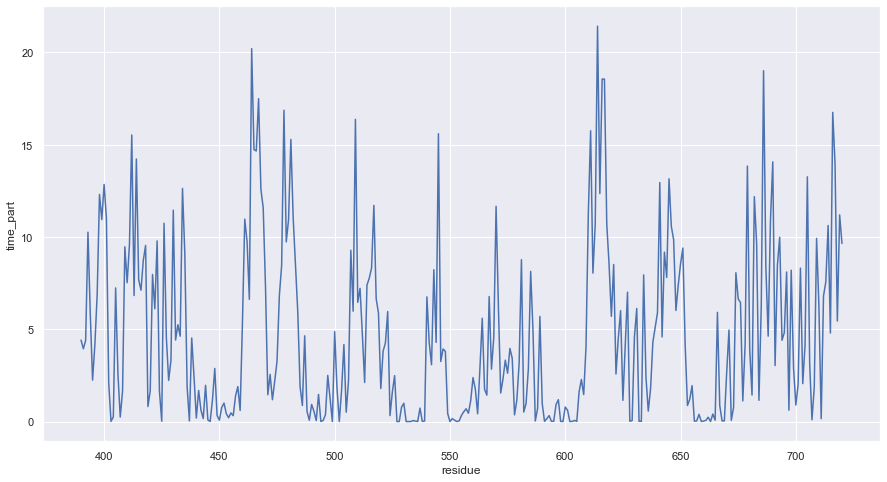

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(15,8)})
sns.lineplot(data=do3153nt_profile, x='residue', y='time_part')

<BarContainer object of 328 artists>

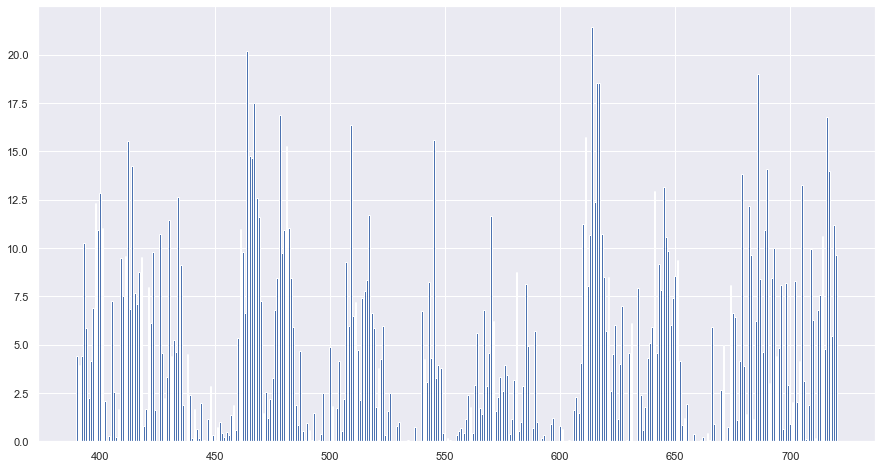

In [10]:
plt.bar(do3153nt_profile['residue'], do3153nt_profile['time_part'])

In [11]:
do3153nt_profile = do3153nt_profile.sort_values(by='residue')
do3153nt_profile

restype  residue      system  time_part
289     TYR      390  do315.3.nt   4.412419
40      ASP      391  do315.3.nt   3.944278
124     LEU      392  do315.3.nt   4.397176
263     THR      393  do315.3.nt  10.259870
29      ASN      394  do315.3.nt   5.854198
..      ...      ...         ...        ...
28      ARG      716  do315.3.nt  16.751624
208     MET      717  do315.3.nt  13.970140
94      GLY      718  do315.3.nt   5.446652
82      GLU      719  do315.3.nt  11.197401
179     LEU      720  do315.3.nt   9.649550

[328 rows x 4 columns]

In [12]:
for i in range(390, 721):
    if i not in list(do3153nt_profile.residue):
        do3153nt_profile = do3153nt_profile.append({'restype':'?', 'residue':i, 'system':'do315.3.nt', 'time_part':0}, ignore_index=True)
do3153nt_profile

restype  residue      system  time_part
0       TYR      390  do315.3.nt   4.412419
1       ASP      391  do315.3.nt   3.944278
2       LEU      392  do315.3.nt   4.397176
3       THR      393  do315.3.nt  10.259870
4       ASN      394  do315.3.nt   5.854198
..      ...      ...         ...        ...
326     GLU      719  do315.3.nt  11.197401
327     LEU      720  do315.3.nt   9.649550
328       ?      498  do315.3.nt   0.000000
329       ?      532  do315.3.nt   0.000000
330       ?      535  do315.3.nt   0.000000

[331 rows x 4 columns]

In [13]:
do3153nt_profile = do3153nt_profile.sort_values(by='residue')

In [14]:
do3153nt_profile

restype  residue      system  time_part
0       TYR      390  do315.3.nt   4.412419
1       ASP      391  do315.3.nt   3.944278
2       LEU      392  do315.3.nt   4.397176
3       THR      393  do315.3.nt  10.259870
4       ASN      394  do315.3.nt   5.854198
..      ...      ...         ...        ...
323     ARG      716  do315.3.nt  16.751624
324     MET      717  do315.3.nt  13.970140
325     GLY      718  do315.3.nt   5.446652
326     GLU      719  do315.3.nt  11.197401
327     LEU      720  do315.3.nt   9.649550

[331 rows x 4 columns]

Дальше смерджить, посчитать разницу и рисовать

_______

# do315.1.w и ds315.1.w 400-500 нс

In [15]:
do3151w = pd.read_csv('water/do315.1.w_water_400000_dc_ft.csv', header=None, sep='\s+').drop(columns=5)
do3151w.columns = list(i for i in range(0, 11))
do3151w[10] = do3151w[10].apply(lambda x:x[1:]).astype(float)
do3151w['system'] = 'do315.1.w'
do3151w = do3151w.rename(columns={1:'water_number', 3:'type', 6: 'subunit', 8:'restype', 9:'residue', 10:'time_part_do'})
do3151w.head()

0  water_number  2 type  4  5  subunit    7 restype  residue  time_part_do  \
0  4         53664  0  SOL  1  1        1  574     SER      688           1.0   
1  4         34521  0  SOL  1  1        1  480     TYR      594           1.0   
2  4         53664  0  SOL  1  1        1  460     MET      574           1.0   
3  4         53664  0  SOL  1  1        1  456     GLN      570           1.0   
4  4         31339  0  SOL  1  3        3  300     ASP      414           1.0   

      system  
0  do315.1.w  
1  do315.1.w  
2  do315.1.w  
3  do315.1.w  
4  do315.1.w

In [16]:
ds3151w = pd.read_csv('water/ds315.1.w_water_400000_dc_ft.csv', header=None, sep='\s+').drop(columns=5)
ds3151w.columns = list(i for i in range(0, 11))
ds3151w[10] = ds3151w[10].apply(lambda x:x[1:]).astype(float)
ds3151w['system'] = 'ds315.1.w'
ds3151w = ds3151w.rename(columns={1:'water_number', 3:'type', 6: 'subunit', 8:'restype', 9:'residue', 10:'time_part_ds'})
ds3151w.head()

0  water_number  2 type  4  5  subunit    7 restype  residue  time_part_ds  \
0  4         49245  0  SOL  1  2        2  273     ASP      391           1.0   
1  4         44284  0  SOL  1  0        0  273     ASP      391           1.0   
2  4         16956  0  SOL  1  2        2  580     ARG      698           1.0   
3  4         51760  0  SOL  1  0        0  534     ILE      652           1.0   
4  4         78223  0  SOL  1  3        3  457     TYR      575           1.0   

      system  
0  ds315.1.w  
1  ds315.1.w  
2  ds315.1.w  
3  ds315.1.w  
4  ds315.1.w

In [17]:
do3151w_profile = do3151w.groupby(['subunit', 'restype', 'residue', 'system'], as_index=False) \
    .agg({'time_part_do':'sum'})
do3151w_profile = do3151w_profile.groupby(['restype', 'residue', 'system'], as_index=False) \
    .agg({'time_part_do':'mean'}).sort_values(by='residue')

In [18]:
ds3151w_profile = ds3151w.groupby(['subunit', 'restype', 'residue', 'system'], as_index=False) \
    .agg({'time_part_ds':'sum'})
ds3151w_profile = ds3151w_profile.groupby(['restype', 'residue', 'system'], as_index=False) \
    .agg({'time_part_ds':'mean'}).sort_values(by='residue')

In [19]:
for i in range(390, 721):
    if i not in list(do3151w_profile.residue):
        do3151w_profile = do3151w_profile.append({'restype':'?', 'residue':i, 'system':'do315.1.w', 'time_part_do':0}, ignore_index=True)
    if i not in list(ds3151w_profile.residue):
        ds3151w_profile = ds3151w_profile.append({'restype':'?', 'residue':i, 'system':'ds315.1.w', 'time_part_ds':0}, ignore_index=True)

In [20]:
print(sum(i not in list(do3151w_profile.residue) for i in range(390, 721)))
print(sum(i not in list(ds3151w_profile.residue) for i in range(390, 721)))

0
0


In [21]:
do3151w_profile

restype  residue     system  time_part_do
292     TYR      390  do315.1.w      4.447901
40      ASP      391  do315.1.w      5.288731
124     LEU      392  do315.1.w      3.867066
266     THR      393  do315.1.w      9.221139
29      ASN      394  do315.1.w      7.845827
..      ...      ...        ...           ...
28      ARG      716  do315.1.w     15.260870
210     MET      717  do315.1.w     14.920915
94      GLY      718  do315.1.w      6.928911
82      GLU      719  do315.1.w     11.740755
181     LEU      720  do315.1.w      5.302099

[331 rows x 4 columns]

In [22]:
profile_1 = do3151w_profile.loc[:, ['residue', 'time_part_do']].merge(
    ds3151w_profile.loc[:, ['residue', 'time_part_ds']],
    on='residue')
profile_1['do-ds'] = profile_1.time_part_do - profile_1.time_part_ds

In [23]:
profile_1['ds-do'] = profile_1['do-ds'] * (-1)

In [24]:
profile_1 = profile_1.sort_values(by='residue')

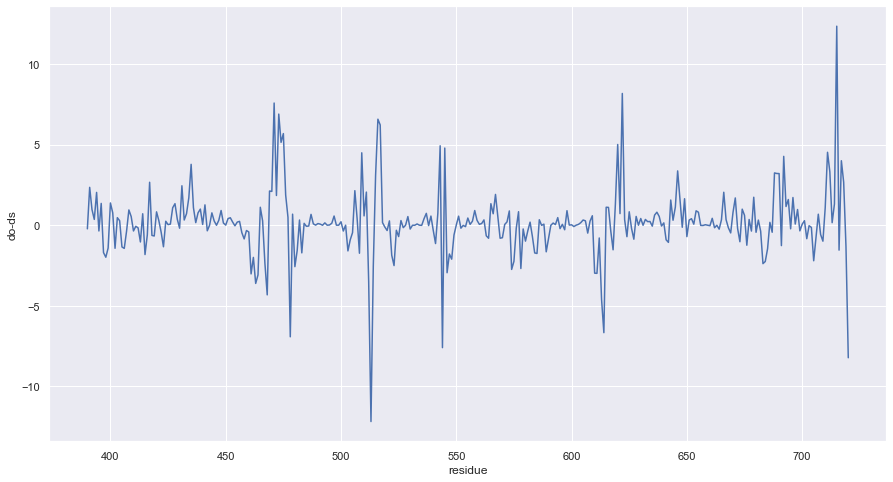

In [25]:
sns.set(rc={'figure.figsize':(15,8)})
profile_1_plot = sns.lineplot(data=profile_1, x='residue', y='do-ds')

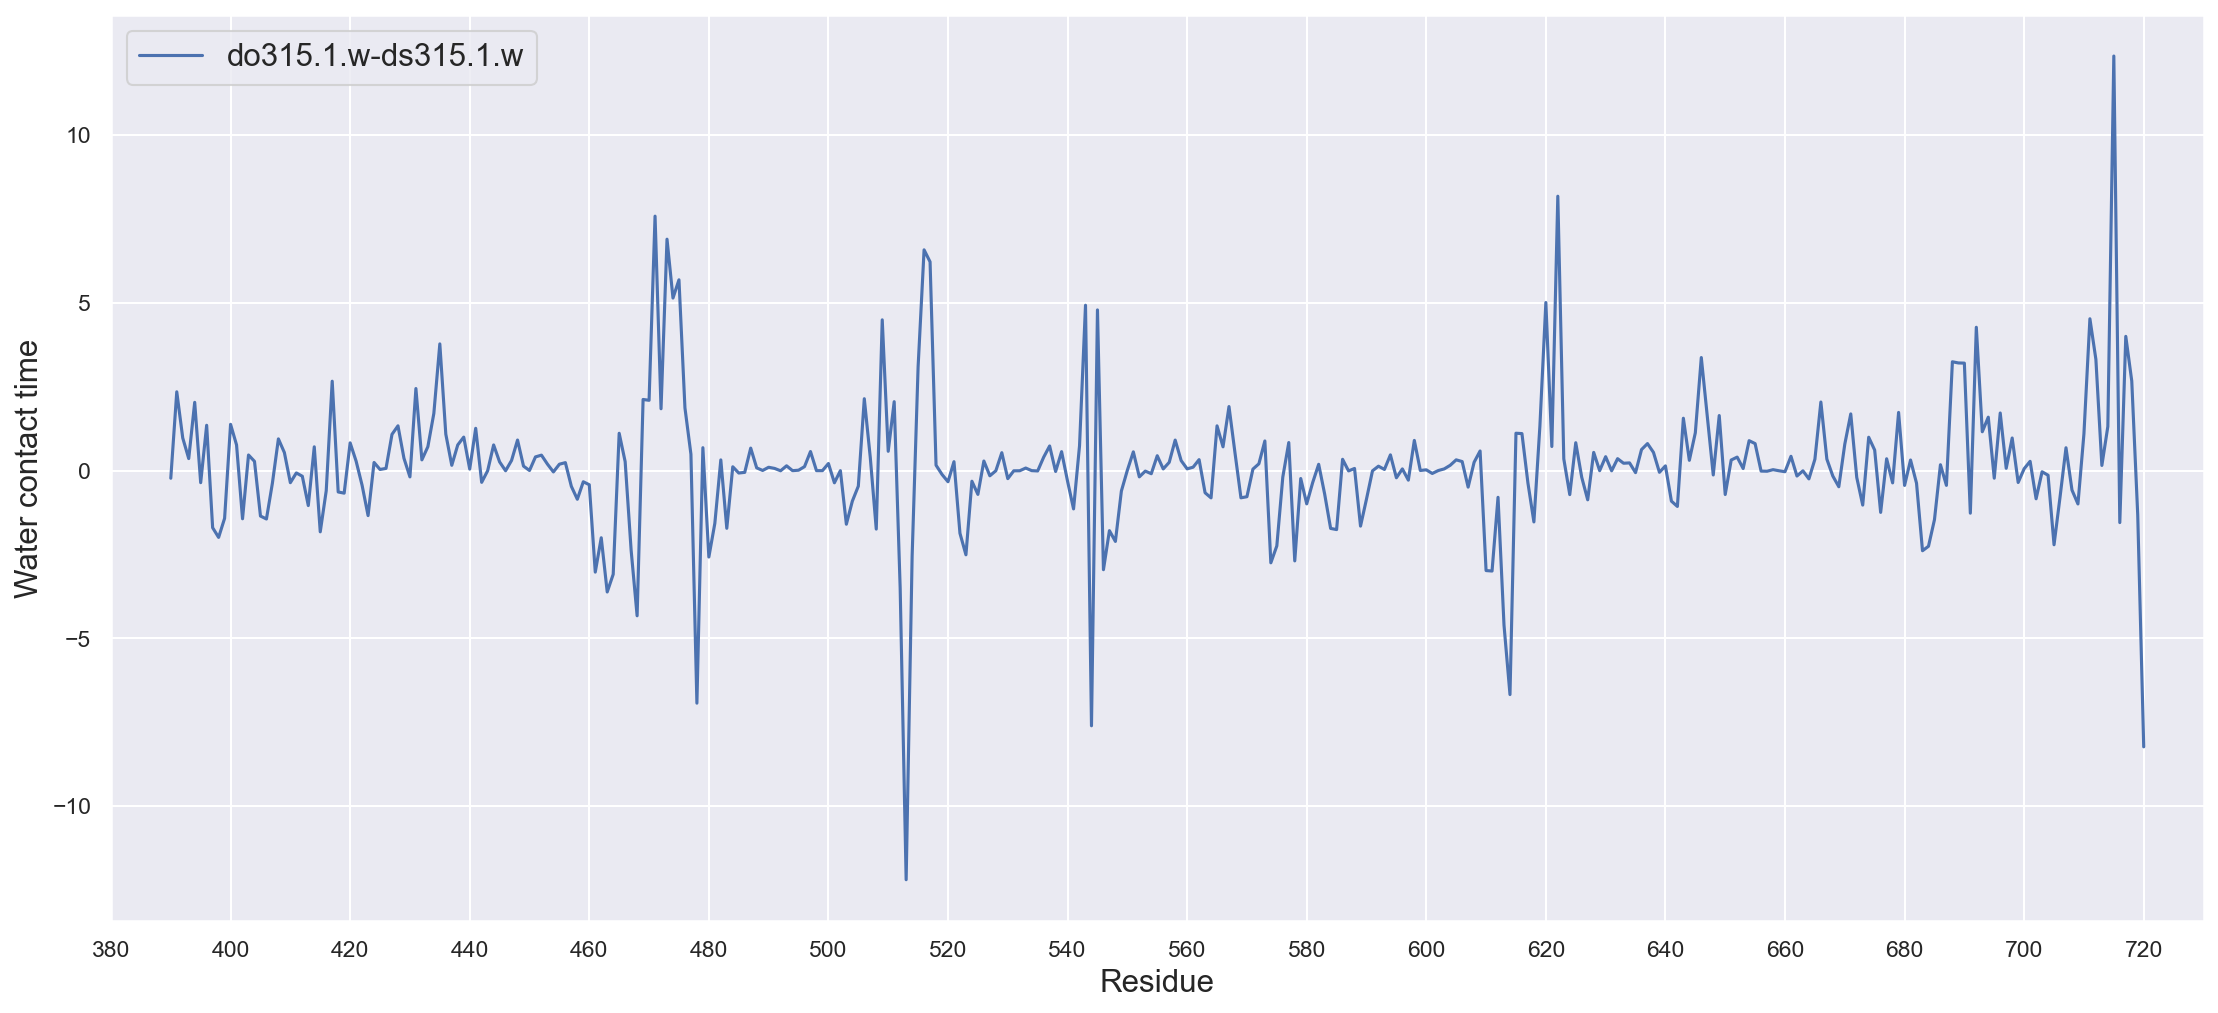

In [26]:
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(18)
fig.set_dpi(150)

from matplotlib import ticker
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))

ax.set_xlim([380, 730])
ax.plot(profile_1.residue, profile_1['do-ds'], label='do315.1.w-ds315.1.w')
ax.set_xlabel('Residue', fontsize=15)
ax.set_ylabel('Water contact time', fontsize=15)
ax.legend(prop={'size': 15})
#ax.set_title('Мощность лазера 2.5 мВт, длительность регистрации 30 с', fontsize=25)

# do315.3.nt - ds315.3.w 400-500

In [27]:
do3153nt = pd.read_csv('water/do315.3.nt_water_400000_dc_ft.csv', header=None, sep='\s+').drop(columns=5)
do3153nt.columns = list(i for i in range(0, 11))
do3153nt[10] = do3153nt[10].apply(lambda x:x[1:]).astype(float)
do3153nt['system'] = 'do315.3.nt'
do3153nt = do3153nt.rename(columns={1:'water_number', 3:'type', 6: 'subunit', 8:'restype', 9:'residue', 10:'time_part_do'})

ds3153w = pd.read_csv('water/ds315.3.w_water_400000_dc_ft.csv', header=None, sep='\s+').drop(columns=5)
ds3153w.columns = list(i for i in range(0, 11))
ds3153w[10] = ds3153w[10].apply(lambda x:x[1:]).astype(float)
ds3153w['system'] = 'ds315.3.w'
ds3153w = ds3153w.rename(columns={1:'water_number', 3:'type', 6: 'subunit', 8:'restype', 9:'residue', 10:'time_part_ds'})

do3153nt_profile = do3153nt.groupby(['subunit', 'restype', 'residue', 'system'], as_index=False) \
    .agg({'time_part_do':'sum'})
do3153nt_profile = do3153nt_profile.groupby(['restype', 'residue', 'system'], as_index=False) \
    .agg({'time_part_do':'mean'}).sort_values(by='residue')

ds3153w_profile = ds3153w.groupby(['subunit', 'restype', 'residue', 'system'], as_index=False) \
    .agg({'time_part_ds':'sum'})
ds3153w_profile = ds3153w_profile.groupby(['restype', 'residue', 'system'], as_index=False) \
    .agg({'time_part_ds':'mean'}).sort_values(by='residue')

for i in range(390, 721):
    if i not in list(do3153nt_profile.residue):
        do3153nt_profile = do3153nt_profile.append({'restype':'?', 'residue':i, 'system':'do315.3.nt', 'time_part_do':0}, ignore_index=True)
    if i not in list(ds3153w_profile.residue):
        ds3153w_profile = ds3153w_profile.append({'restype':'?', 'residue':i, 'system':'ds315.3.w', 'time_part_ds':0}, ignore_index=True)
        
print(sum(i not in list(do3153nt_profile.residue) for i in range(390, 721)))
print(sum(i not in list(ds3153w_profile.residue) for i in range(390, 721)))

0
0


In [28]:
profile_3 = do3153nt_profile.loc[:, ['residue', 'time_part_do']].merge(
    ds3153w_profile.loc[:, ['residue', 'time_part_ds']],
    on='residue')
profile_3['do-ds'] = profile_3.time_part_do - profile_3.time_part_ds

In [29]:
profile_3 = profile_3.sort_values(by='residue')

In [30]:
profile_3

residue  time_part_do  time_part_ds     do-ds
0        390      4.412419      4.824588 -0.412169
1        391      3.944278      2.998626  0.945652
2        392      4.397176      3.912419  0.484758
3        393     10.259870      9.736257  0.523613
4        394      5.854198      6.910420 -1.056222
..       ...           ...           ...       ...
323      716     16.751624     15.557346  1.194278
324      717     13.970140     11.484758  2.485382
325      718      5.446652      5.669040 -0.222389
326      719     11.197401     10.282984  0.914418
327      720      9.649550     14.622689 -4.973138

[331 rows x 4 columns]

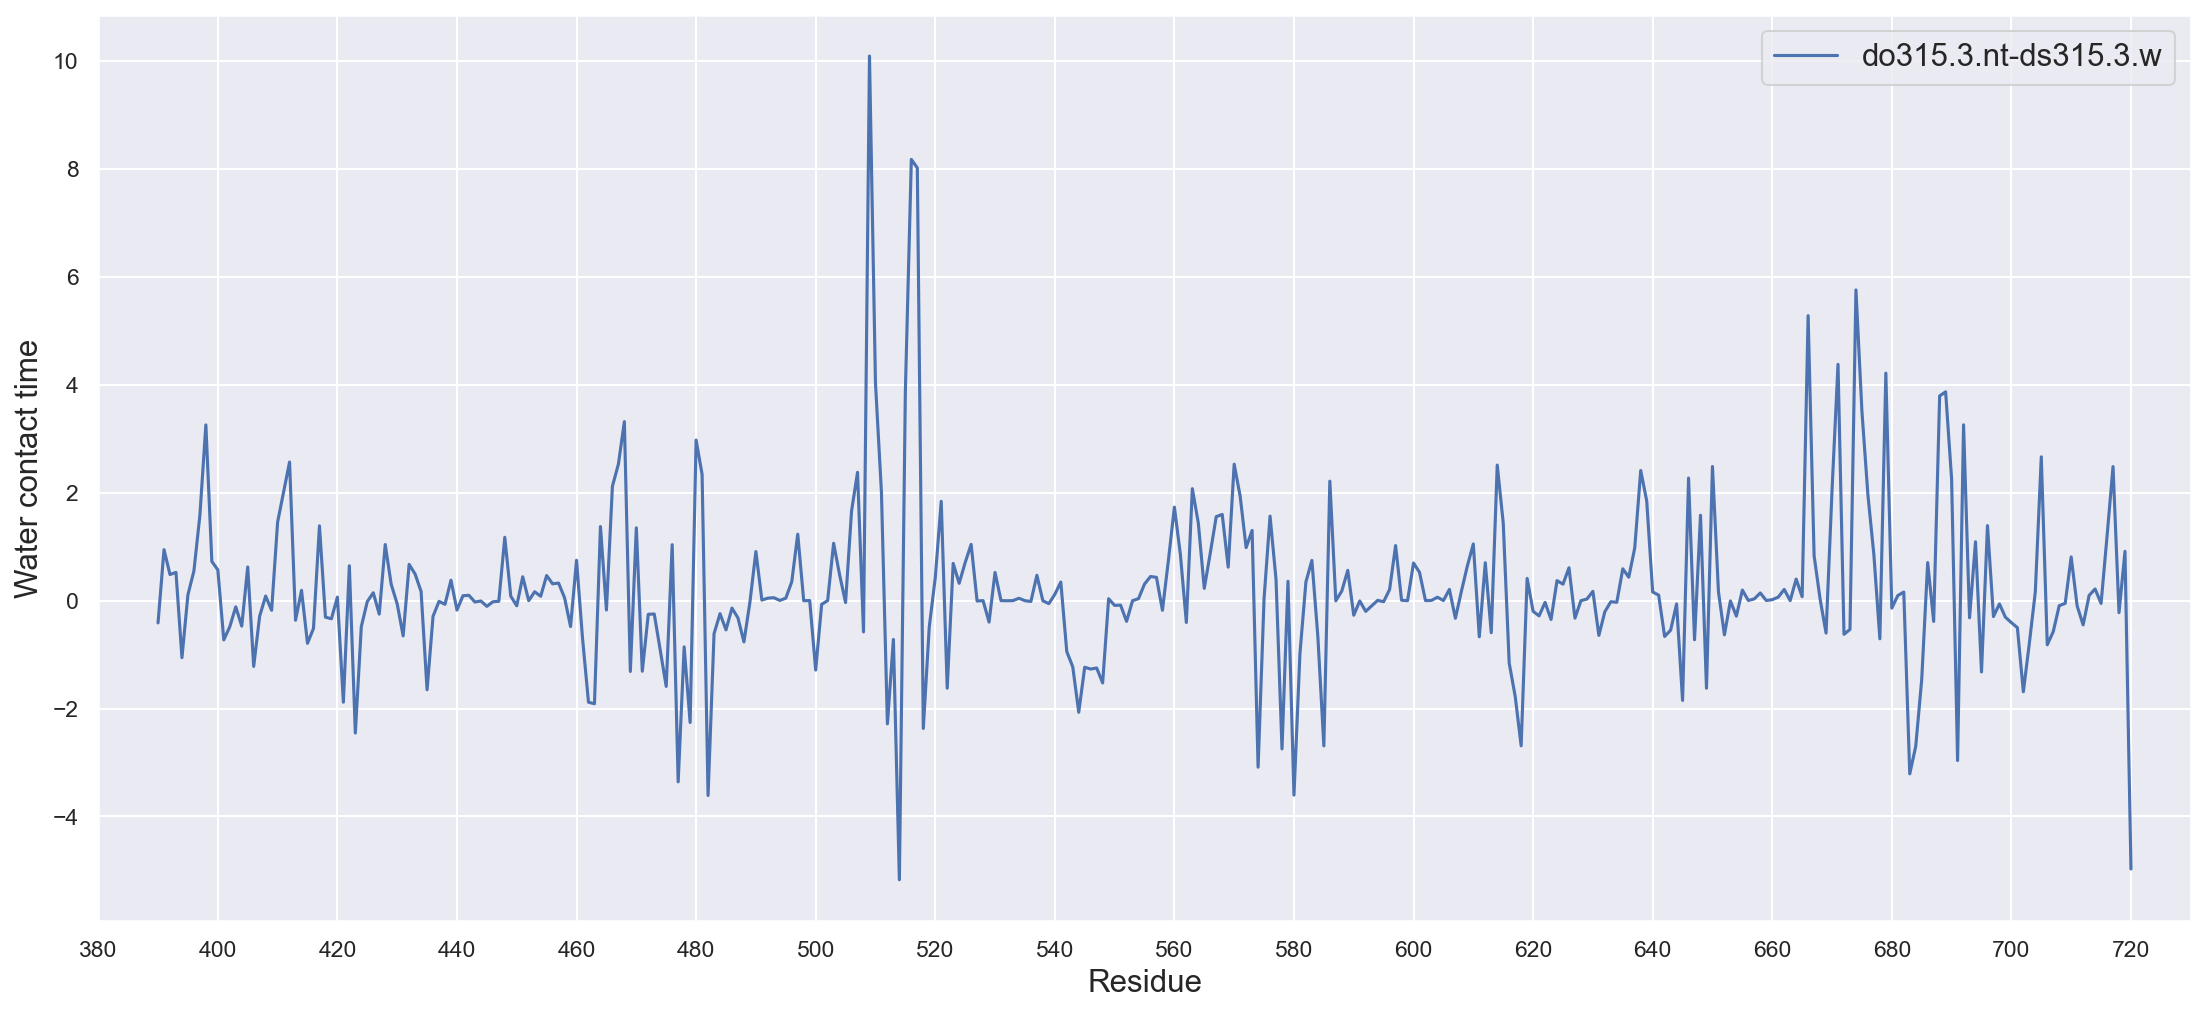

In [31]:
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(18)
fig.set_dpi(150)

from matplotlib import ticker
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))

ax.set_xlim([380, 730])
ax.plot(profile_3.residue, profile_3['do-ds'], label='do315.3.nt-ds315.3.w')
ax.set_xlabel('Residue', fontsize=15)
ax.set_ylabel('Water contact time', fontsize=15)
ax.legend(prop={'size': 15})

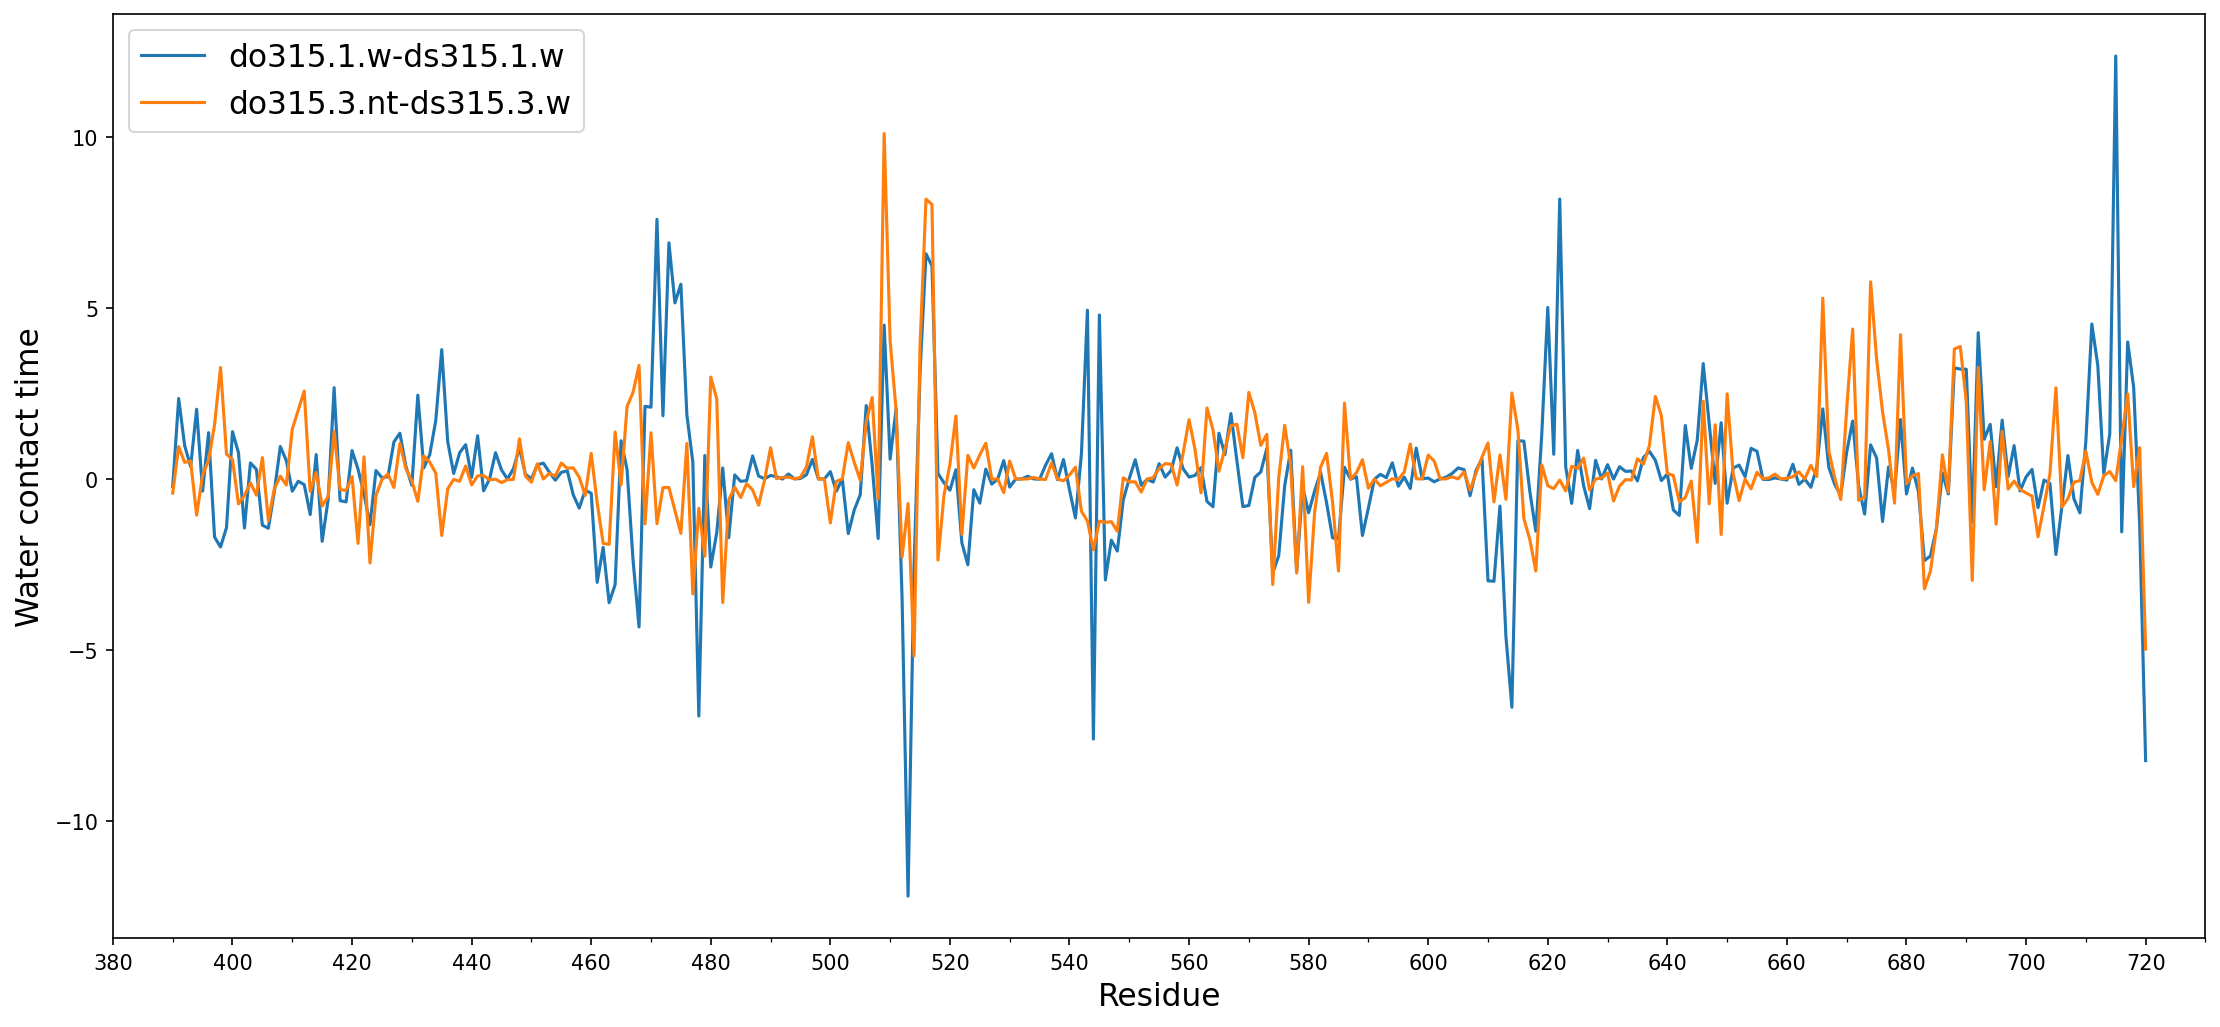

In [32]:
plt.style.use('default')
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(18)
fig.set_dpi(150)

from matplotlib import ticker
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))

ax.set_xlim([380, 730])
ax.plot(profile_1.residue, profile_1['do-ds'], label='do315.1.w-ds315.1.w')
ax.plot(profile_3.residue, profile_3['do-ds'], label='do315.3.nt-ds315.3.w')
ax.set_xlabel('Residue', fontsize=15)
ax.set_ylabel('Water contact time', fontsize=15)
ax.legend(prop={'size': 15})

0
0
0
0


KeyError: 'do-ds'

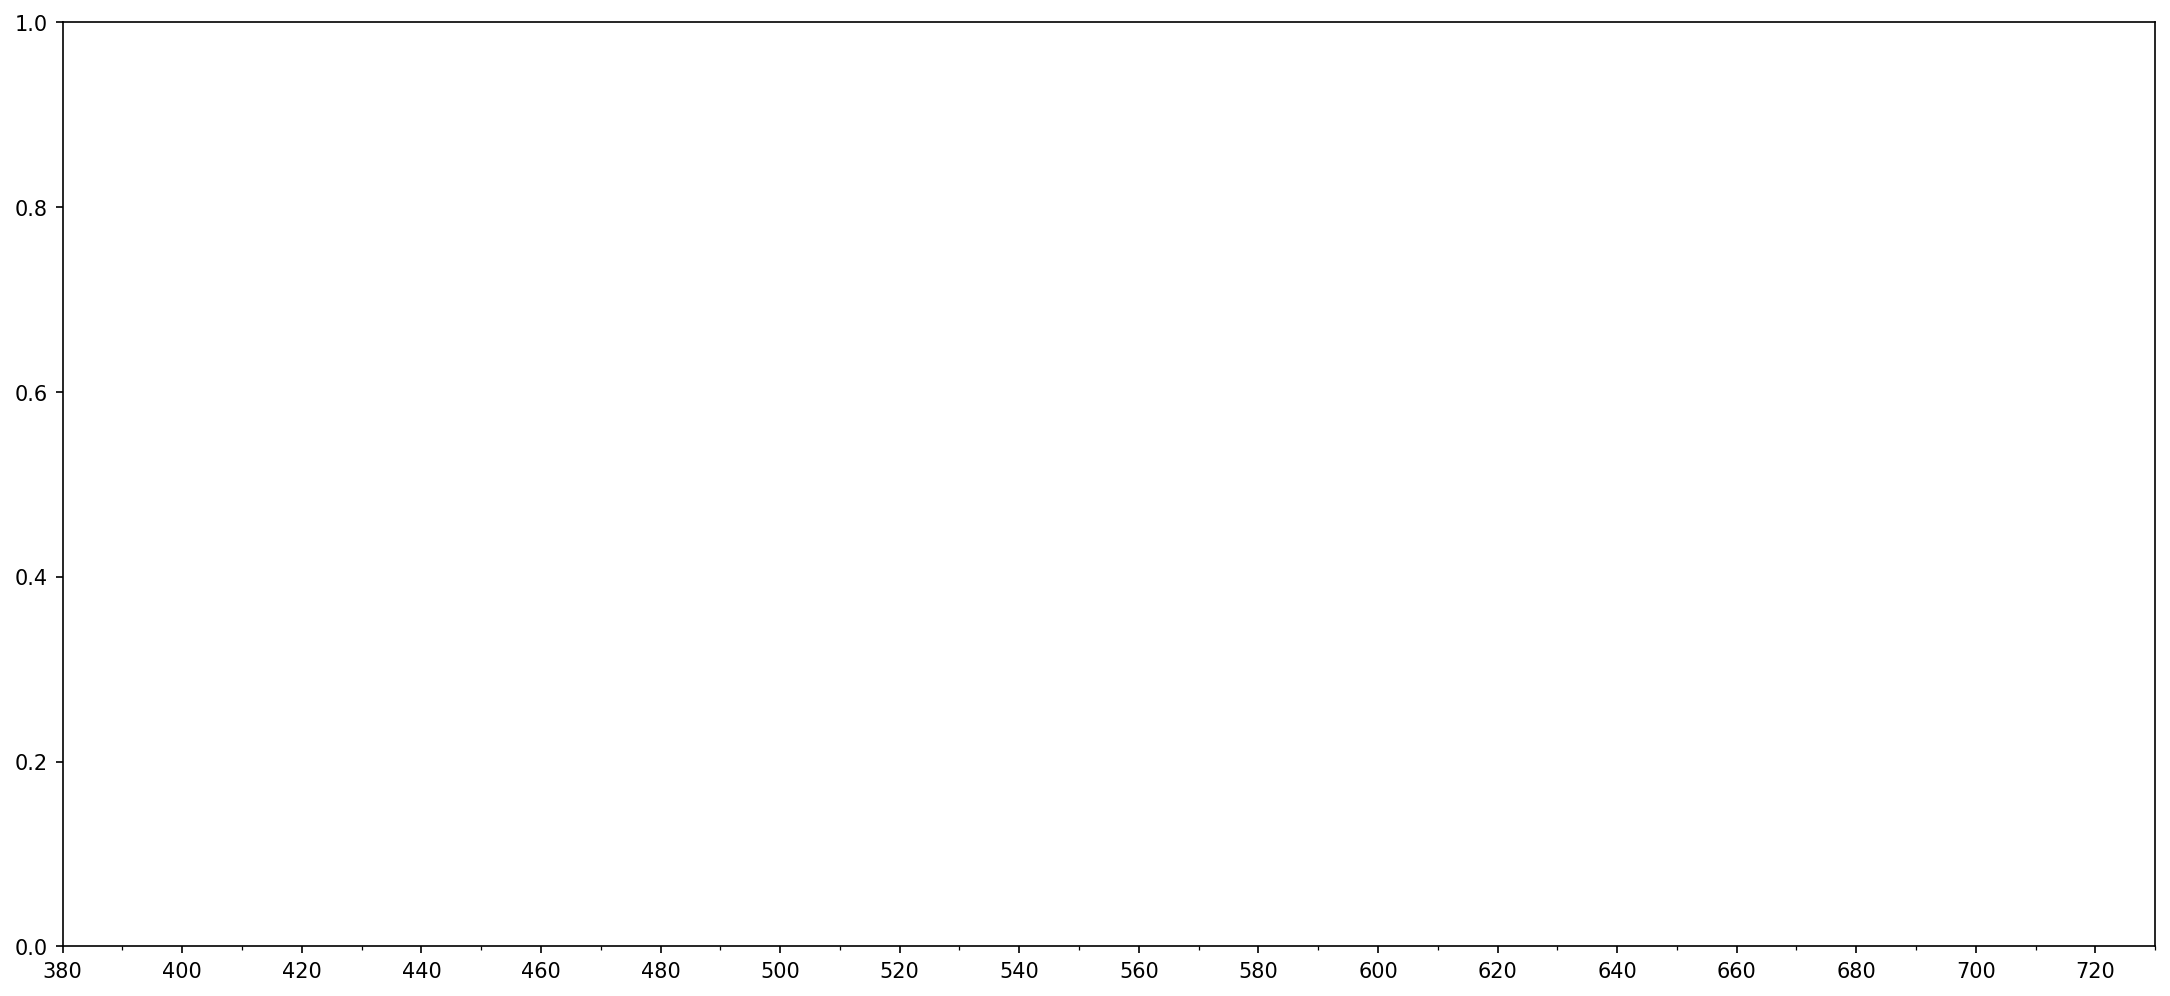

In [33]:
test_1 = do_minus_ds(do_file='water/do315.1.w_water_400000_dc_ft.csv', ds_file='water/ds315.1.w_water_400000_dc_ft.csv', water=True)
test_3 = do_minus_ds(do_file='water/do315.3.nt_water_400000_dc_ft.csv', ds_file='water/ds315.3.w_water_400000_dc_ft.csv', water=True)

plt.style.use('default')
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(18)
fig.set_dpi(150)

from matplotlib import ticker
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))

ax.set_xlim([380, 730])
ax.plot(test_1.residue, test_1['do-ds'], label='do315.1.w-ds315.1.w')
ax.plot(test_3.residue, test_3['do-ds'], label='do315.3.nt-ds315.3.w')
ax.set_xlabel('Residue', fontsize=15)
ax.set_ylabel('Water contact time', fontsize=15)
ax.legend(prop={'size': 15})

# lipids  
То же самое, но с липидами

## do315.3.nt-ds315.3.w

In [ ]:
do3153nt_l = pd.read_csv('water/do315.3.nt_lipids_400000_dc_ft.csv', header=None, sep='\s+').drop(columns=5)
do3153nt_l.columns = list(i for i in range(0, 11))
do3153nt_l[10] = do3153nt_l[10].apply(lambda x:x[1:]).astype(float)
do3153nt_l['system'] = 'do315.3.nt'
do3153nt_l = do3153nt_l.rename(columns={1:'lipid_number', 3:'lipid_type', 6: 'subunit', 8:'restype', 9:'residue', 10:'time_part_do'})

ds3153w_l = pd.read_csv('water/ds315.3.w_lipids_400000_dc_ft.csv', header=None, sep='\s+').drop(columns=5)
ds3153w_l.columns = list(i for i in range(0, 11))
ds3153w_l[10] = ds3153w_l[10].apply(lambda x:x[1:]).astype(float)
ds3153w_l['system'] = 'ds315.3.w'
ds3153w_l = ds3153w_l.rename(columns={1:'lipid_number', 3:'lipid_type', 6: 'subunit', 8:'restype', 9:'residue', 10:'time_part_ds'})

do3153nt_l_profile = do3153nt_l.groupby(['subunit', 'restype', 'residue', 'system'], as_index=False) \
    .agg({'time_part_do':'sum'})
do3153nt_l_profile = do3153nt_l_profile.groupby(['restype', 'residue', 'system'], as_index=False) \
    .agg({'time_part_do':'mean'}).sort_values(by='residue')

ds3153w_l_profile = ds3153w_l.groupby(['subunit', 'restype', 'residue', 'system'], as_index=False) \
    .agg({'time_part_ds':'sum'})
ds3153w_l_profile = ds3153w_l_profile.groupby(['restype', 'residue', 'system'], as_index=False) \
    .agg({'time_part_ds':'mean'}).sort_values(by='residue')

for i in range(390, 721):
    if i not in list(do3153nt_l_profile.residue):
        do3153nt_l_profile = do3153nt_l_profile.append({'restype':'?', 'residue':i, 'system':'do315.3.nt', 'time_part_do':0}, ignore_index=True)
    if i not in list(ds3153w_l_profile.residue):
        ds3153w_l_profile = ds3153w_l_profile.append({'restype':'?', 'residue':i, 'system':'ds315.3.w', 'time_part_ds':0}, ignore_index=True)
        
print(sum(i not in list(do3153nt_l_profile.residue) for i in range(390, 721)))
print(sum(i not in list(ds3153w_l_profile.residue) for i in range(390, 721)))

profile_3_l = do3153nt_l_profile.loc[:, ['residue', 'restype', 'time_part_do']].merge(
    ds3153w_l_profile.loc[:, ['residue', 'restype', 'time_part_ds']], on='residue').sort_values(by='residue')
profile_3_l['do-ds'] = profile_3_l.time_part_do - profile_3_l.time_part_ds

In [ ]:
profile_3_l

In [ ]:
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(18)
fig.set_dpi(150)

from matplotlib import ticker
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))

ax.set_xlim([380, 730])
ax.plot(profile_3_l.residue, profile_3_l['do-ds'], label='do315.3.nt-ds315.3.w')
ax.set_xlabel('Residue', fontsize=15)
ax.set_ylabel('Lipid contact time', fontsize=15)
ax.grid()
ax.legend(prop={'size': 15})

## do315.1.w - ds315.1.w

In [ ]:
do3151w_l = pd.read_csv('water/do315.1.w_lipids_400000_dc_ft.csv', header=None, sep='\s+').drop(columns=5)
do3151w_l.columns = list(i for i in range(0, 11))
do3151w_l[10] = do3151w_l[10].apply(lambda x:x[1:]).astype(float)
do3151w_l['system'] = 'do315.1.w'
do3151w_l = do3151w_l.rename(columns={1:'lipid_number', 3:'lipid_type', 6: 'subunit', 8:'restype', 9:'residue', 10:'time_part_do'})

ds3151w_l = pd.read_csv('water/ds315.1.w_lipids_400000_dc_ft.csv', header=None, sep='\s+').drop(columns=5)
ds3151w_l.columns = list(i for i in range(0, 11))
ds3151w_l[10] = ds3151w_l[10].apply(lambda x:x[1:]).astype(float)
ds3151w_l['system'] = 'ds315.1.w'
ds3151w_l = ds3151w_l.rename(columns={1:'lipid_number', 3:'lipid_type', 6: 'subunit', 8:'restype', 9:'residue', 10:'time_part_ds'})

do3151w_l_profile = do3151w_l.groupby(['subunit', 'restype', 'residue', 'system'], as_index=False) \
    .agg({'time_part_do':'sum'})
do3151w_l_profile = do3151w_l_profile.groupby(['restype', 'residue', 'system'], as_index=False) \
    .agg({'time_part_do':'mean'}).sort_values(by='residue')

ds3151w_l_profile = ds3151w_l.groupby(['subunit', 'restype', 'residue', 'system'], as_index=False) \
    .agg({'time_part_ds':'sum'})
ds3151w_l_profile = ds3151w_l_profile.groupby(['restype', 'residue', 'system'], as_index=False) \
    .agg({'time_part_ds':'mean'}).sort_values(by='residue')

for i in range(390, 721):
    if i not in list(do3151w_l_profile.residue):
        do3151w_l_profile = do3151w_l_profile.append({'restype':'?', 'residue':i, 'system':'do315.1.w', 'time_part_do':0}, ignore_index=True)
    if i not in list(ds3151w_l_profile.residue):
        ds3151w_l_profile = ds3151w_l_profile.append({'restype':'?', 'residue':i, 'system':'ds315.1.w', 'time_part_ds':0}, ignore_index=True)
        
print(sum(i not in list(do3151w_l_profile.residue) for i in range(390, 721)))
print(sum(i not in list(ds3151w_l_profile.residue) for i in range(390, 721)))

profile_1_l = do3151w_l_profile.loc[:, ['residue', 'restype', 'time_part_do']].merge(
    ds3151w_l_profile.loc[:, ['residue', 'restype', 'time_part_ds']], on='residue').sort_values(by='residue')
profile_1_l['do-ds'] = profile_1_l.time_part_do - profile_1_l.time_part_ds

In [ ]:
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(18)
fig.set_dpi(150)

from matplotlib import ticker
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))

ax.set_xlim([380, 730])
ax.plot(profile_1_l.residue, profile_1_l['do-ds'], label='do315.1.w-ds315.1.w')
ax.set_xlabel('Residue', fontsize=15)
ax.set_ylabel('Lipid contact time', fontsize=15)
ax.grid()
ax.legend(prop={'size': 15})

In [ ]:
plt.style.use('default')
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(18)
fig.set_dpi(150)

from matplotlib import ticker
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))

ax.set_xlim([380, 730])
ax.plot(profile_1_l.residue, profile_1_l['do-ds'], label='do315.1.w-ds315.1.w')
ax.plot(profile_3_l.residue, profile_3_l['do-ds'], label='do315.3.nt-ds315.3.w')
ax.set_xlabel('Residue', fontsize=15)
ax.set_ylabel('Lipid contact time', fontsize=15)
ax.legend(prop={'size': 15})
ax.grid()

In [ ]:
test_1_l = do_minus_ds(do_file='water/do315.1.w_lipids_400000_dc_ft.csv', ds_file='water/ds315.1.w_lipids_400000_dc_ft.csv', lipids=True)
test_3_l = do_minus_ds(do_file='water/do315.3.nt_lipids_400000_dc_ft.csv', ds_file='water/ds315.3.w_lipids_400000_dc_ft.csv', lipids=True)

plt.style.use('default')
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(18)
fig.set_dpi(150)

from matplotlib import ticker
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))

ax.set_xlim([380, 730])
ax.plot(test_1_l.residue, test_1_l['do-ds'], label='do315.1.w-ds315.1.w')
ax.plot(test_3_l.residue, test_3_l['do-ds'], label='do315.3.nt-ds315.3.w')
ax.set_xlabel('Residue', fontsize=15)
ax.set_ylabel('Lipids contact time', fontsize=15)
ax.legend(prop={'size': 15})
ax.grid()

## do315.4.nt-ds315.4.w

### water

In [ ]:
w_4 = do_minus_ds(do_file='water/do315.4.nt_water_400000_dc_ft.csv', ds_file='water/ds315.4.w_water_400000_dc_ft.csv', water=True)

plt.style.use('default')
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(18)
fig.set_dpi(150)

from matplotlib import ticker
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))

ax.set_xlim([380, 730])
ax.plot(w_4.residue, w_4['do-ds'], label='do315.4.nt-ds315.4.w')
ax.set_xlabel('Residue', fontsize=15)
ax.set_ylabel('Water contact time', fontsize=15)
ax.legend(prop={'size': 15})

# Суммарный график

##  water

0
0
0
0
0
0
0
0


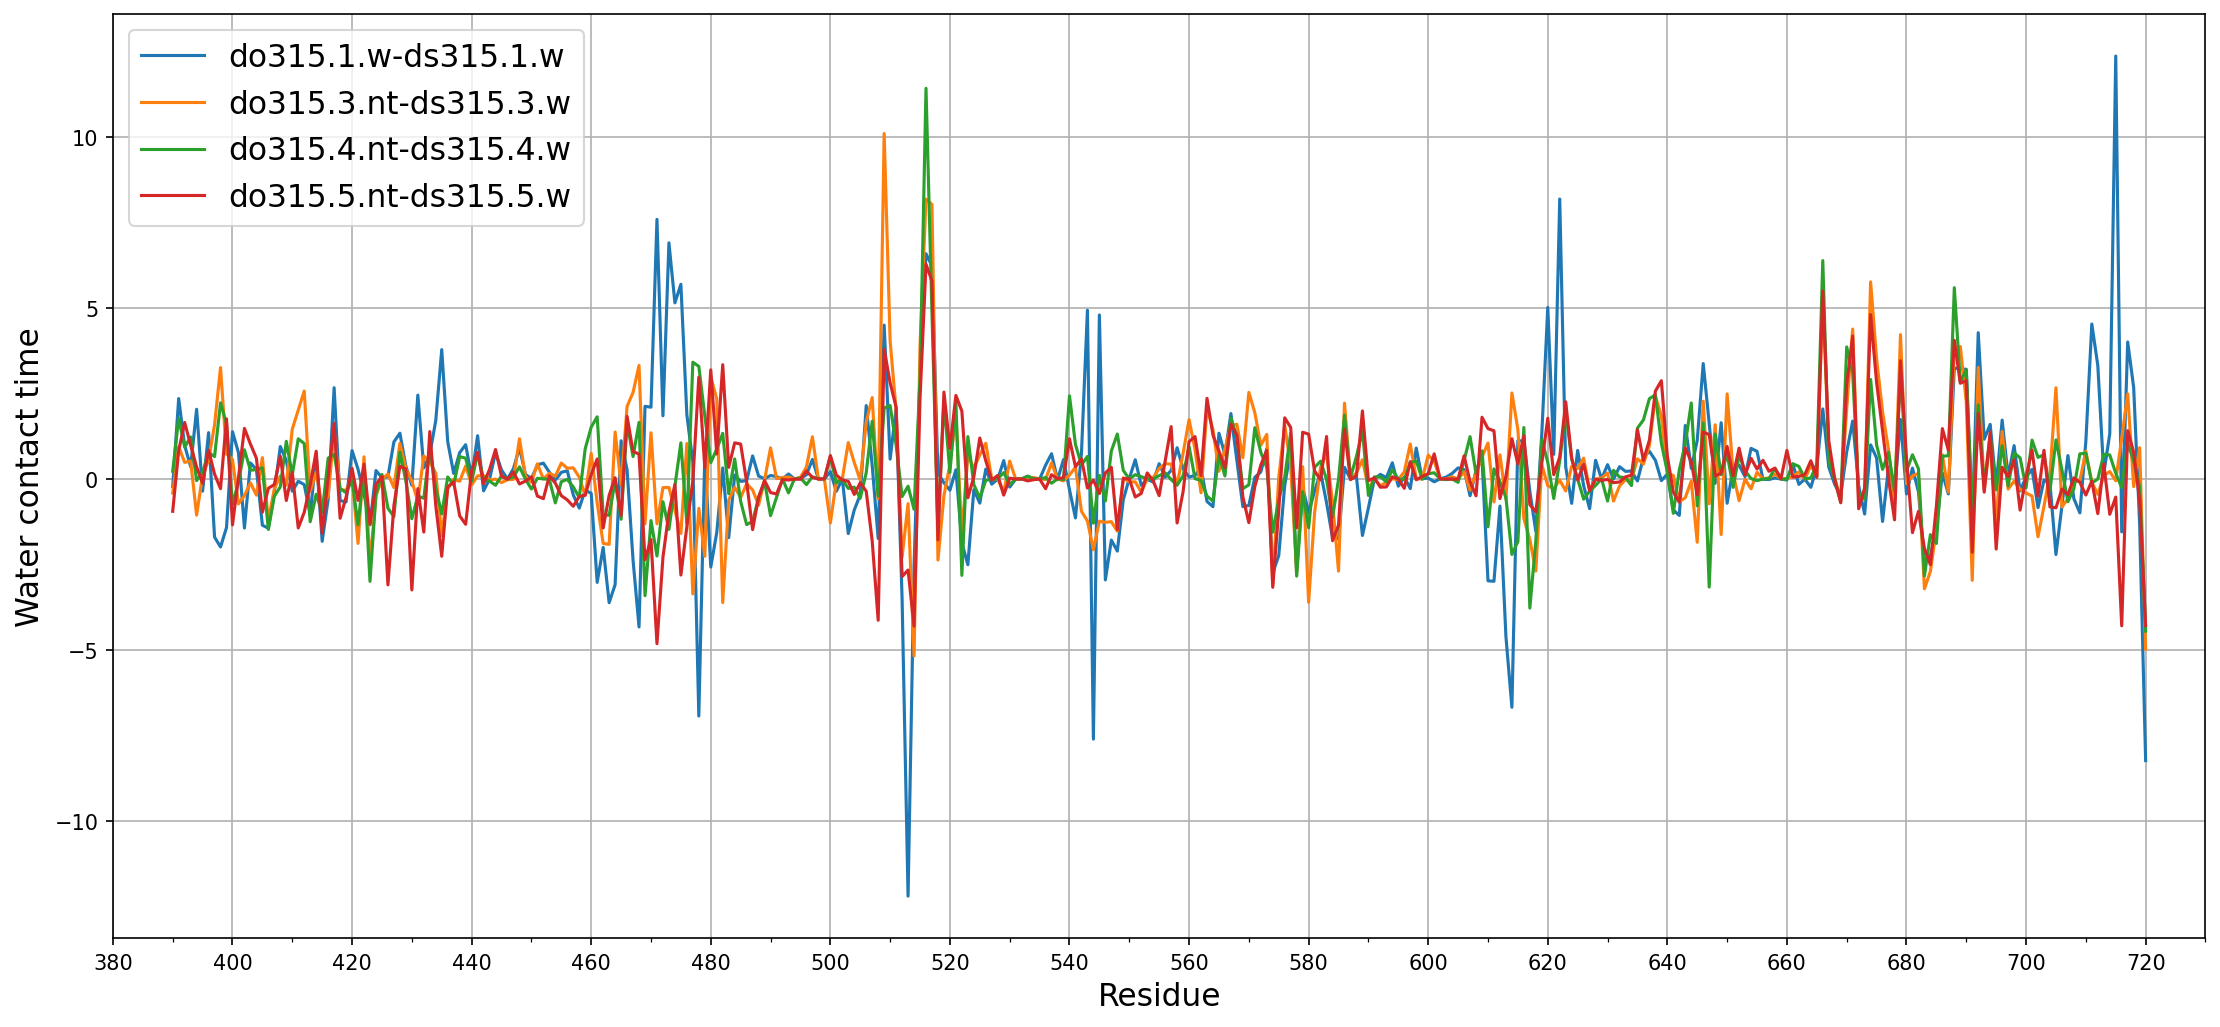

In [36]:
w_1 = do_minus_ds(do_file='water/do315.1.w_water_400000_dc_ft.csv', ds_file='water/ds315.1.w_water_400000_dc_ft.csv', water=True)
w_3 = do_minus_ds(do_file='water/do315.3.nt_water_400000_dc_ft.csv', ds_file='water/ds315.3.w_water_400000_dc_ft.csv', water=True)
w_4 = do_minus_ds(do_file='water/do315.4.nt_water_400000_dc_ft.csv', ds_file='water/ds315.4.w_water_400000_dc_ft.csv', water=True)
w_5 = do_minus_ds(do_file='water/do315.5.nt_water_400000_dc_ft.csv', ds_file='water/ds315.5.w_water_400000_dc_ft.csv', water=True)

plt.style.use('default')
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(18)
fig.set_dpi(150)

from matplotlib import ticker
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))

ax.set_xlim([380, 730])

ax.plot(w_1.residue, w_1['do-ds_1'], label='do315.1.w-ds315.1.w')
ax.plot(w_3.residue, w_3['do-ds_3'], label='do315.3.nt-ds315.3.w')
ax.plot(w_4.residue, w_4['do-ds_4'], label='do315.4.nt-ds315.4.w')
ax.plot(w_5.residue, w_5['do-ds_5'], label='do315.5.nt-ds315.5.w')

ax.set_xlabel('Residue', fontsize=15)
ax.set_ylabel('Water contact time', fontsize=15)
ax.legend(prop={'size': 15})
ax.grid()

## lipids

0
0
0
0
0
0
0
0


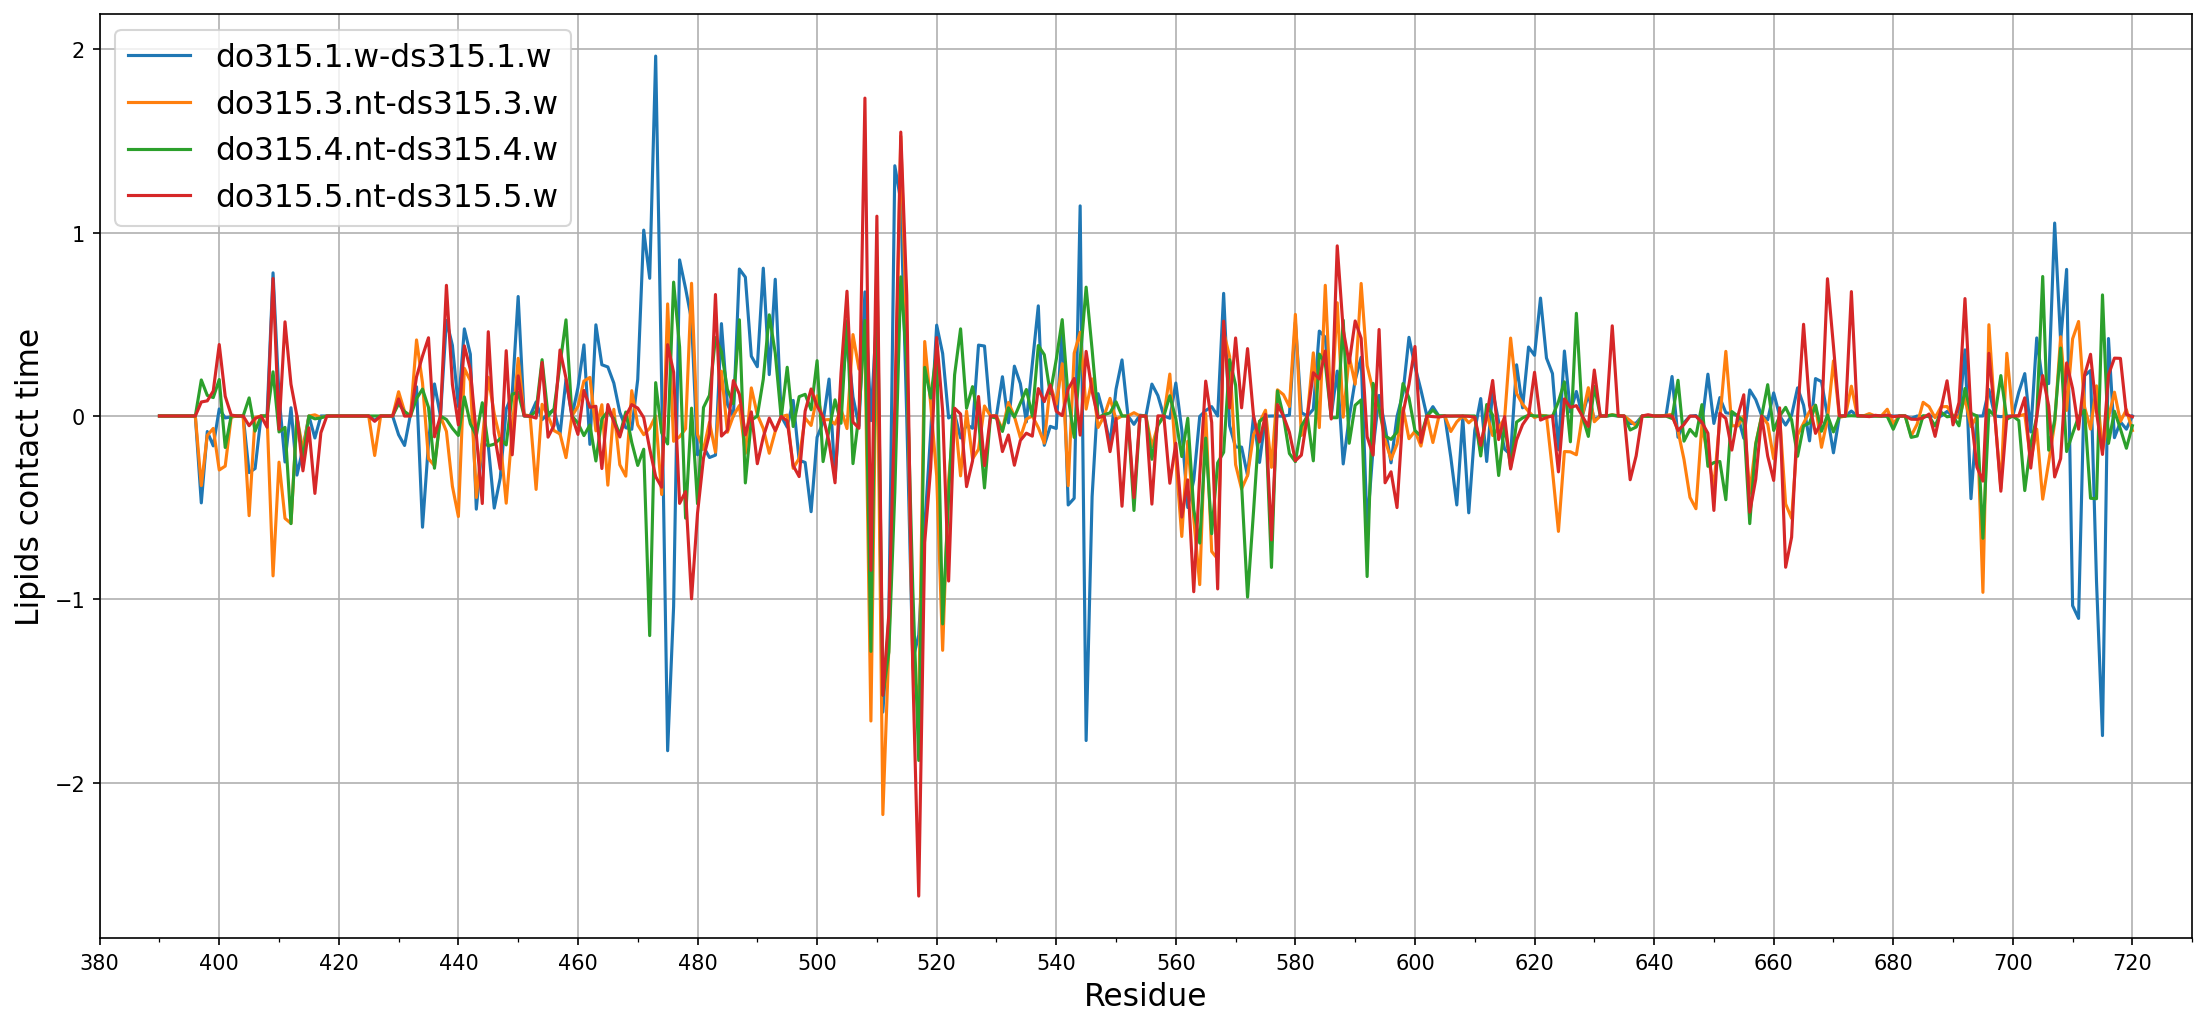

In [37]:
l_1 = do_minus_ds(do_file='water/do315.1.w_lipids_400000_dc_ft.csv', ds_file='water/ds315.1.w_lipids_400000_dc_ft.csv', lipids=True)
l_3 = do_minus_ds(do_file='water/do315.3.nt_lipids_400000_dc_ft.csv', ds_file='water/ds315.3.w_lipids_400000_dc_ft.csv', lipids=True)
l_4 = do_minus_ds(do_file='water/do315.4.nt_lipids_400000_dc_ft.csv', ds_file='water/ds315.4.w_lipids_400000_dc_ft.csv', lipids=True)
l_5 = do_minus_ds(do_file='water/do315.5.nt_lipids_400000_dc_ft.csv', ds_file='water/ds315.5.w_lipids_400000_dc_ft.csv', lipids=True)

plt.style.use('default')
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(18)
fig.set_dpi(150)

from matplotlib import ticker
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))

ax.set_xlim([380, 730])

ax.plot(l_1.residue, l_1['do-ds_1'], label='do315.1.w-ds315.1.w')
ax.plot(l_3.residue, l_3['do-ds_3'], label='do315.3.nt-ds315.3.w')
ax.plot(l_4.residue, l_4['do-ds_4'], label='do315.4.nt-ds315.4.w')
ax.plot(l_5.residue, l_5['do-ds_5'], label='do315.5.nt-ds315.5.w')

ax.set_xlabel('Residue', fontsize=15)
ax.set_ylabel('Lipids contact time', fontsize=15)
ax.legend(prop={'size': 15})
ax.grid()

## Усредним 3, 4, 5

### water

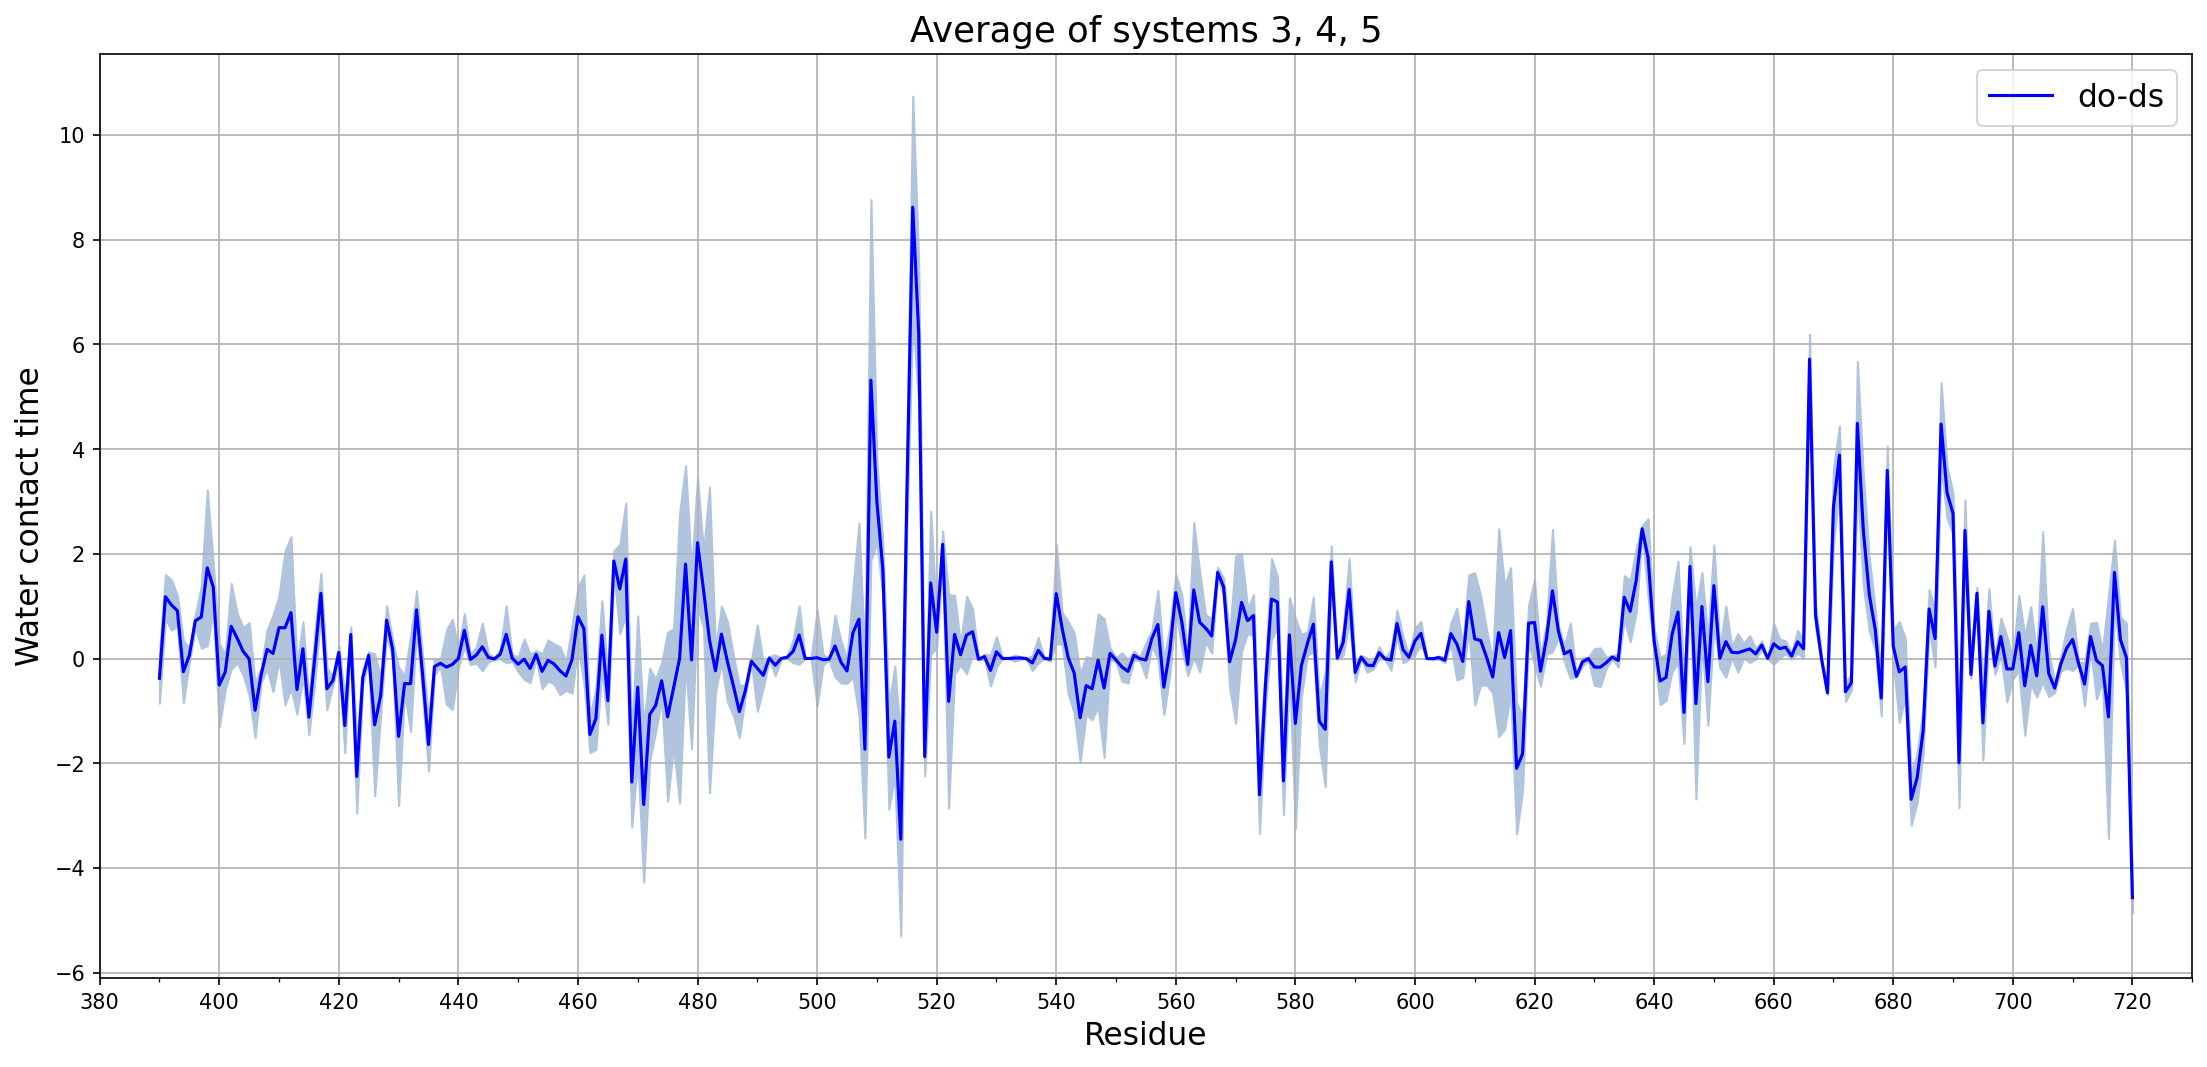

In [38]:
w_345 = w_3[['residue', 'do-ds_3']].merge(w_4[['residue', 'do-ds_4']], on='residue').merge(w_5[['residue', 'do-ds_5']], on='residue')
w_345['do-ds_mean'] = w_345.iloc[:, 1:].mean(axis=1)
w_345['do-ds_std'] = w_345.iloc[:, 1:].std(axis=1)

plt.style.use('default')
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(18)
fig.set_dpi(150)

from matplotlib import ticker
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))

ax.set_xlim([380, 730])

ax.plot(w_345.residue, w_345['do-ds_mean'], label='do-ds', c='blue')
ax.fill_between(w_345.residue, w_345['do-ds_mean']-w_345['do-ds_std'], w_345['do-ds_mean']+w_345['do-ds_std'], color='lightsteelblue')
ax.set_xlabel('Residue', fontsize=15)
ax.set_ylabel('Water contact time', fontsize=15)
ax.set_title('Average of systems 3, 4, 5', fontsize=17)
ax.legend(prop={'size': 15})
ax.grid()

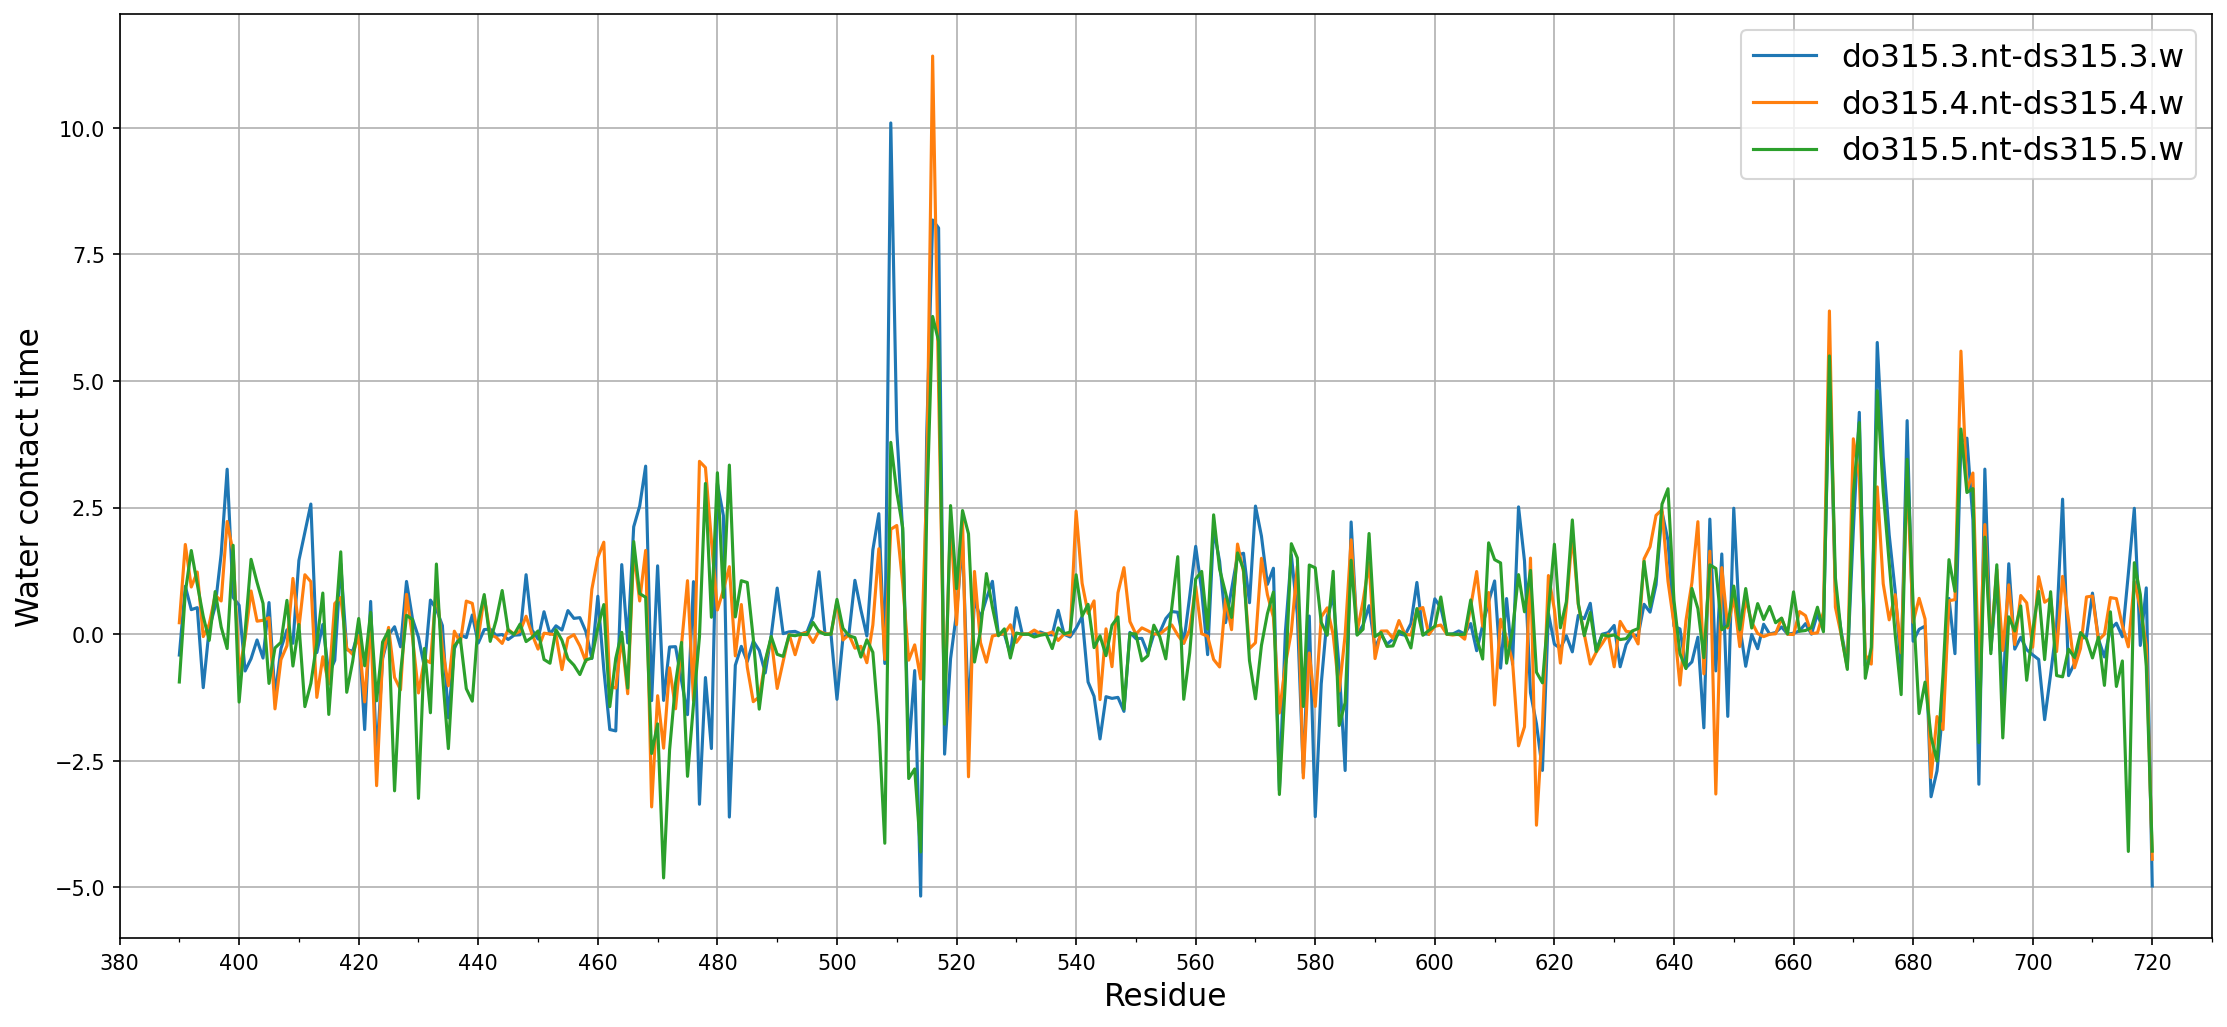

In [39]:
plt.style.use('default')
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(18)
fig.set_dpi(150)

from matplotlib import ticker
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))

ax.set_xlim([380, 730])

ax.plot(w_3.residue, w_3['do-ds_3'], label='do315.3.nt-ds315.3.w')
ax.plot(w_4.residue, w_4['do-ds_4'], label='do315.4.nt-ds315.4.w')
ax.plot(w_5.residue, w_5['do-ds_5'], label='do315.5.nt-ds315.5.w')

ax.set_xlabel('Residue', fontsize=15)
ax.set_ylabel('Water contact time', fontsize=15)
ax.legend(prop={'size': 15})
ax.grid()

## lipids

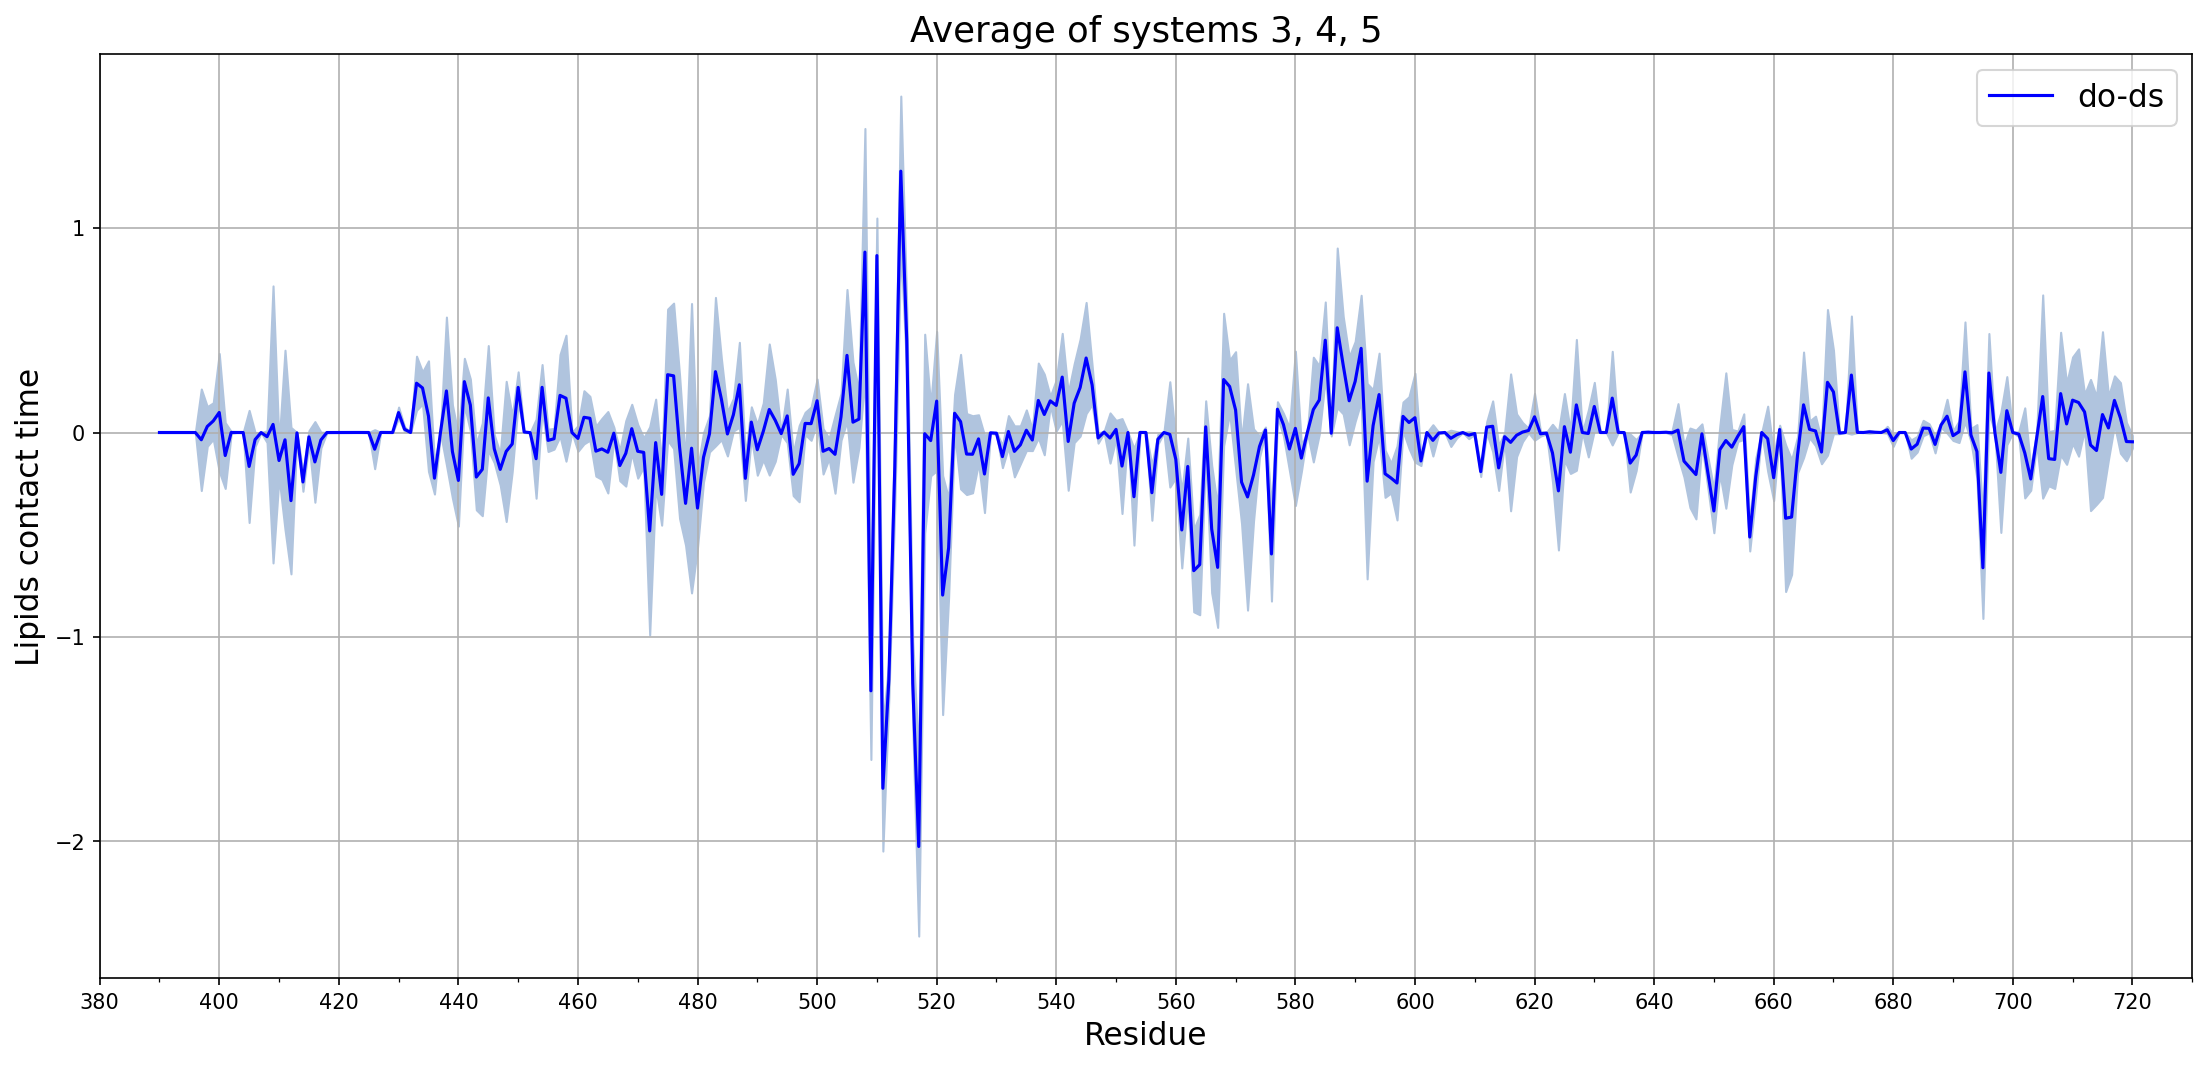

In [40]:
l_345 = l_3[['residue', 'do-ds_3']].merge(l_4[['residue', 'do-ds_4']], on='residue').merge(l_5[['residue', 'do-ds_5']], on='residue')
l_345['do-ds_mean'] = l_345.iloc[:, 1:].mean(axis=1)
l_345['do-ds_std'] = l_345.iloc[:, 1:].std(axis=1)

plt.style.use('default')
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(18)
fig.set_dpi(150)

from matplotlib import ticker
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))

ax.set_xlim([380, 730])

ax.plot(l_345.residue, l_345['do-ds_mean'], label='do-ds', c='blue')
ax.fill_between(l_345.residue, l_345['do-ds_mean']-l_345['do-ds_std'], l_345['do-ds_mean']+l_345['do-ds_std'], color='lightsteelblue')
ax.set_xlabel('Residue', fontsize=15)
ax.set_ylabel('Lipids contact time', fontsize=15)
ax.set_title('Average of systems 3, 4, 5', fontsize=17)
ax.legend(prop={'size': 15})
ax.grid()

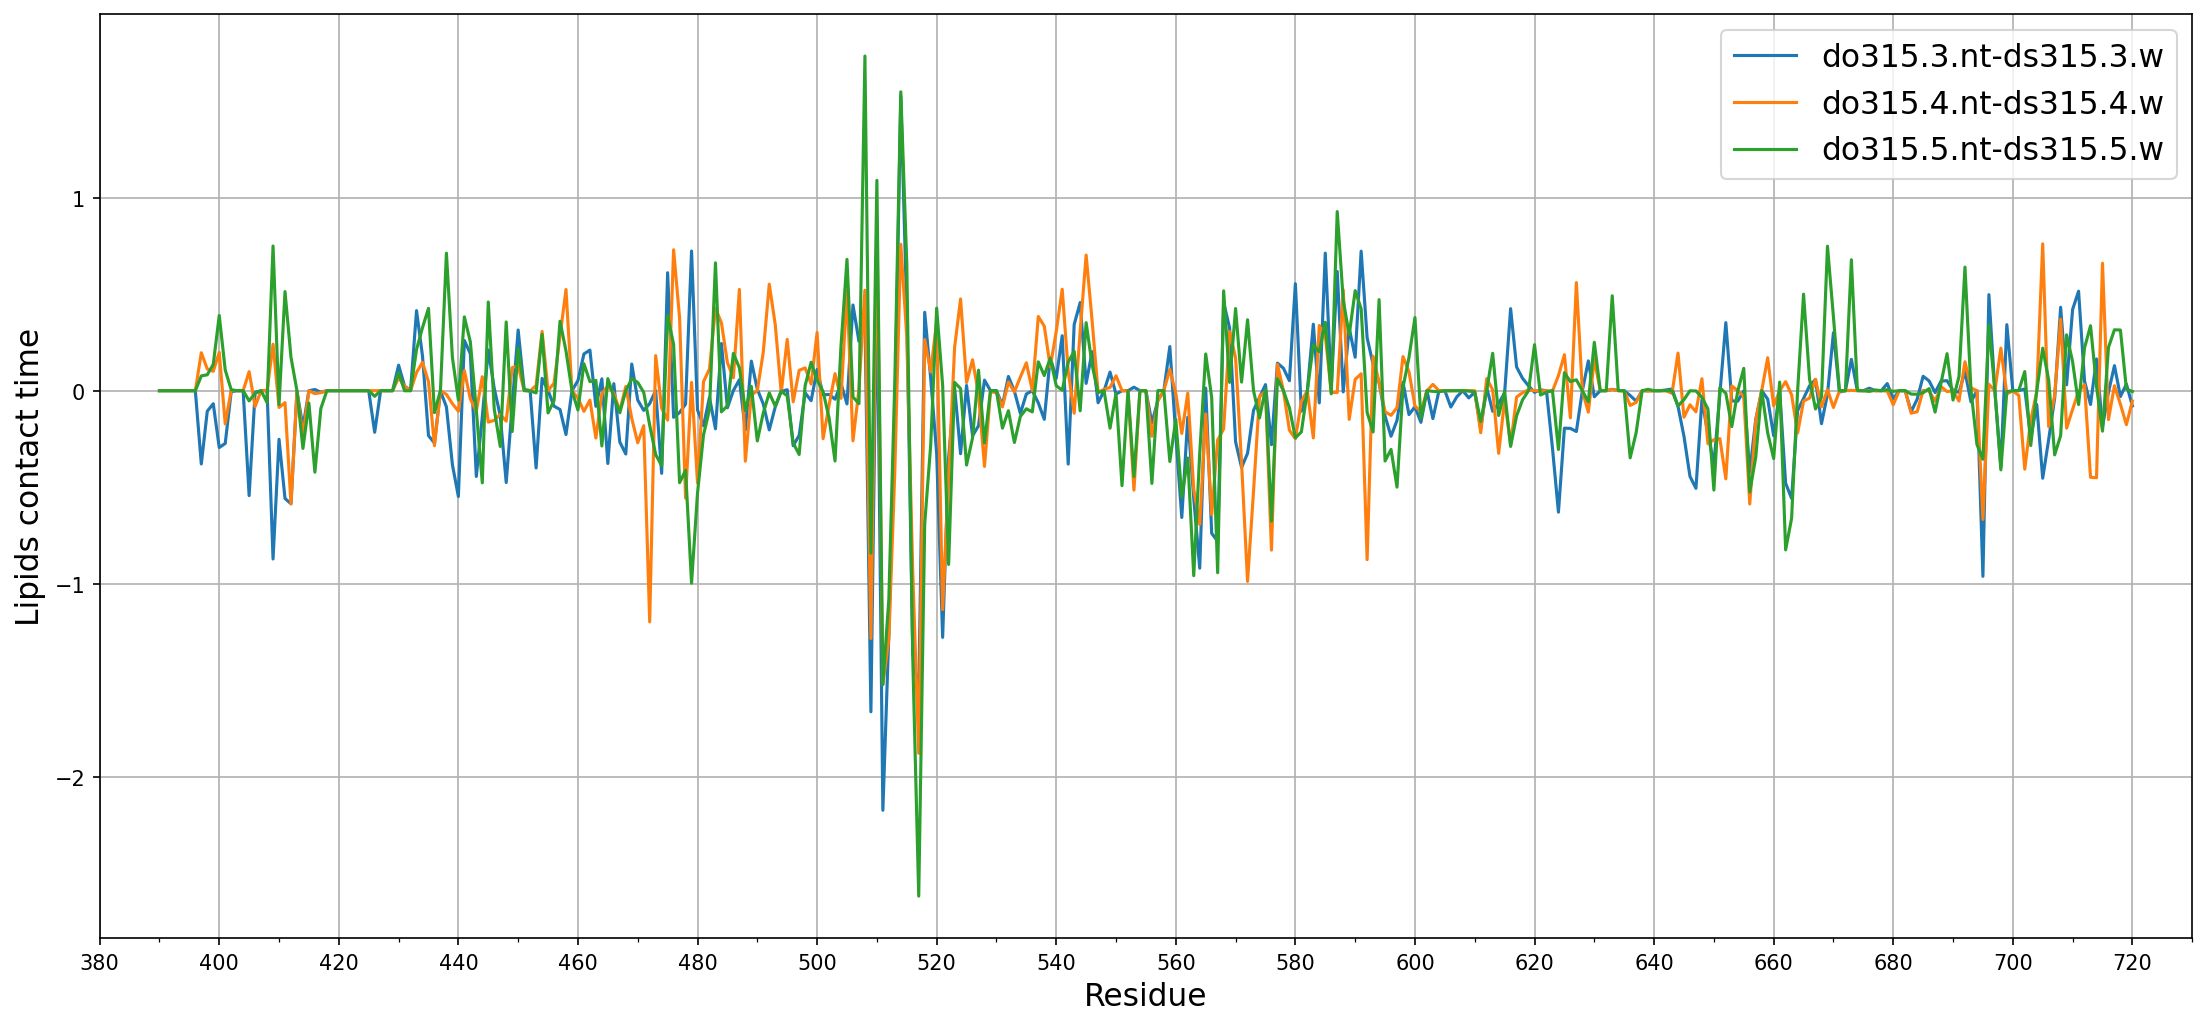

In [41]:
plt.style.use('default')
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(18)
fig.set_dpi(150)

from matplotlib import ticker
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))

ax.set_xlim([380, 730])

ax.plot(l_3.residue, l_3['do-ds_3'], label='do315.3.nt-ds315.3.w')
ax.plot(l_4.residue, l_4['do-ds_4'], label='do315.4.nt-ds315.4.w')
ax.plot(l_5.residue, l_5['do-ds_5'], label='do315.5.nt-ds315.5.w')

ax.set_xlabel('Residue', fontsize=15)
ax.set_ylabel('Lipids contact time', fontsize=15)
ax.legend(prop={'size': 15})
ax.grid()

# Пытаемся добавить аннотации под графиком

Text(1, 1, '228')

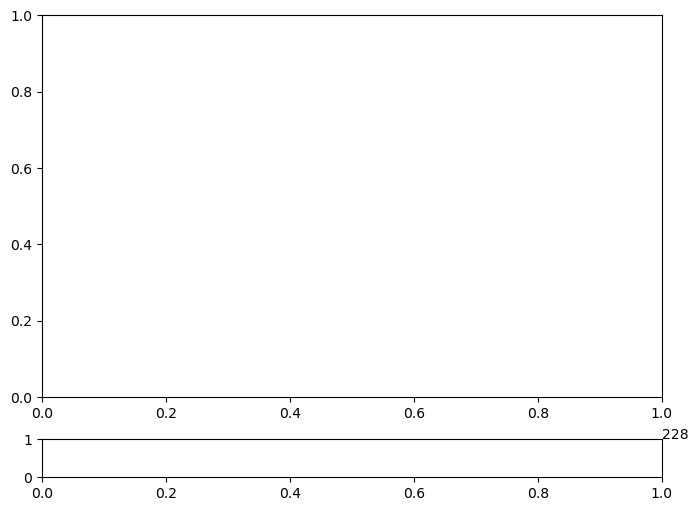

In [42]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[10, 1]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax1.annotate('228', xy=(1, 1))
#ax1.axis('off')

## water 

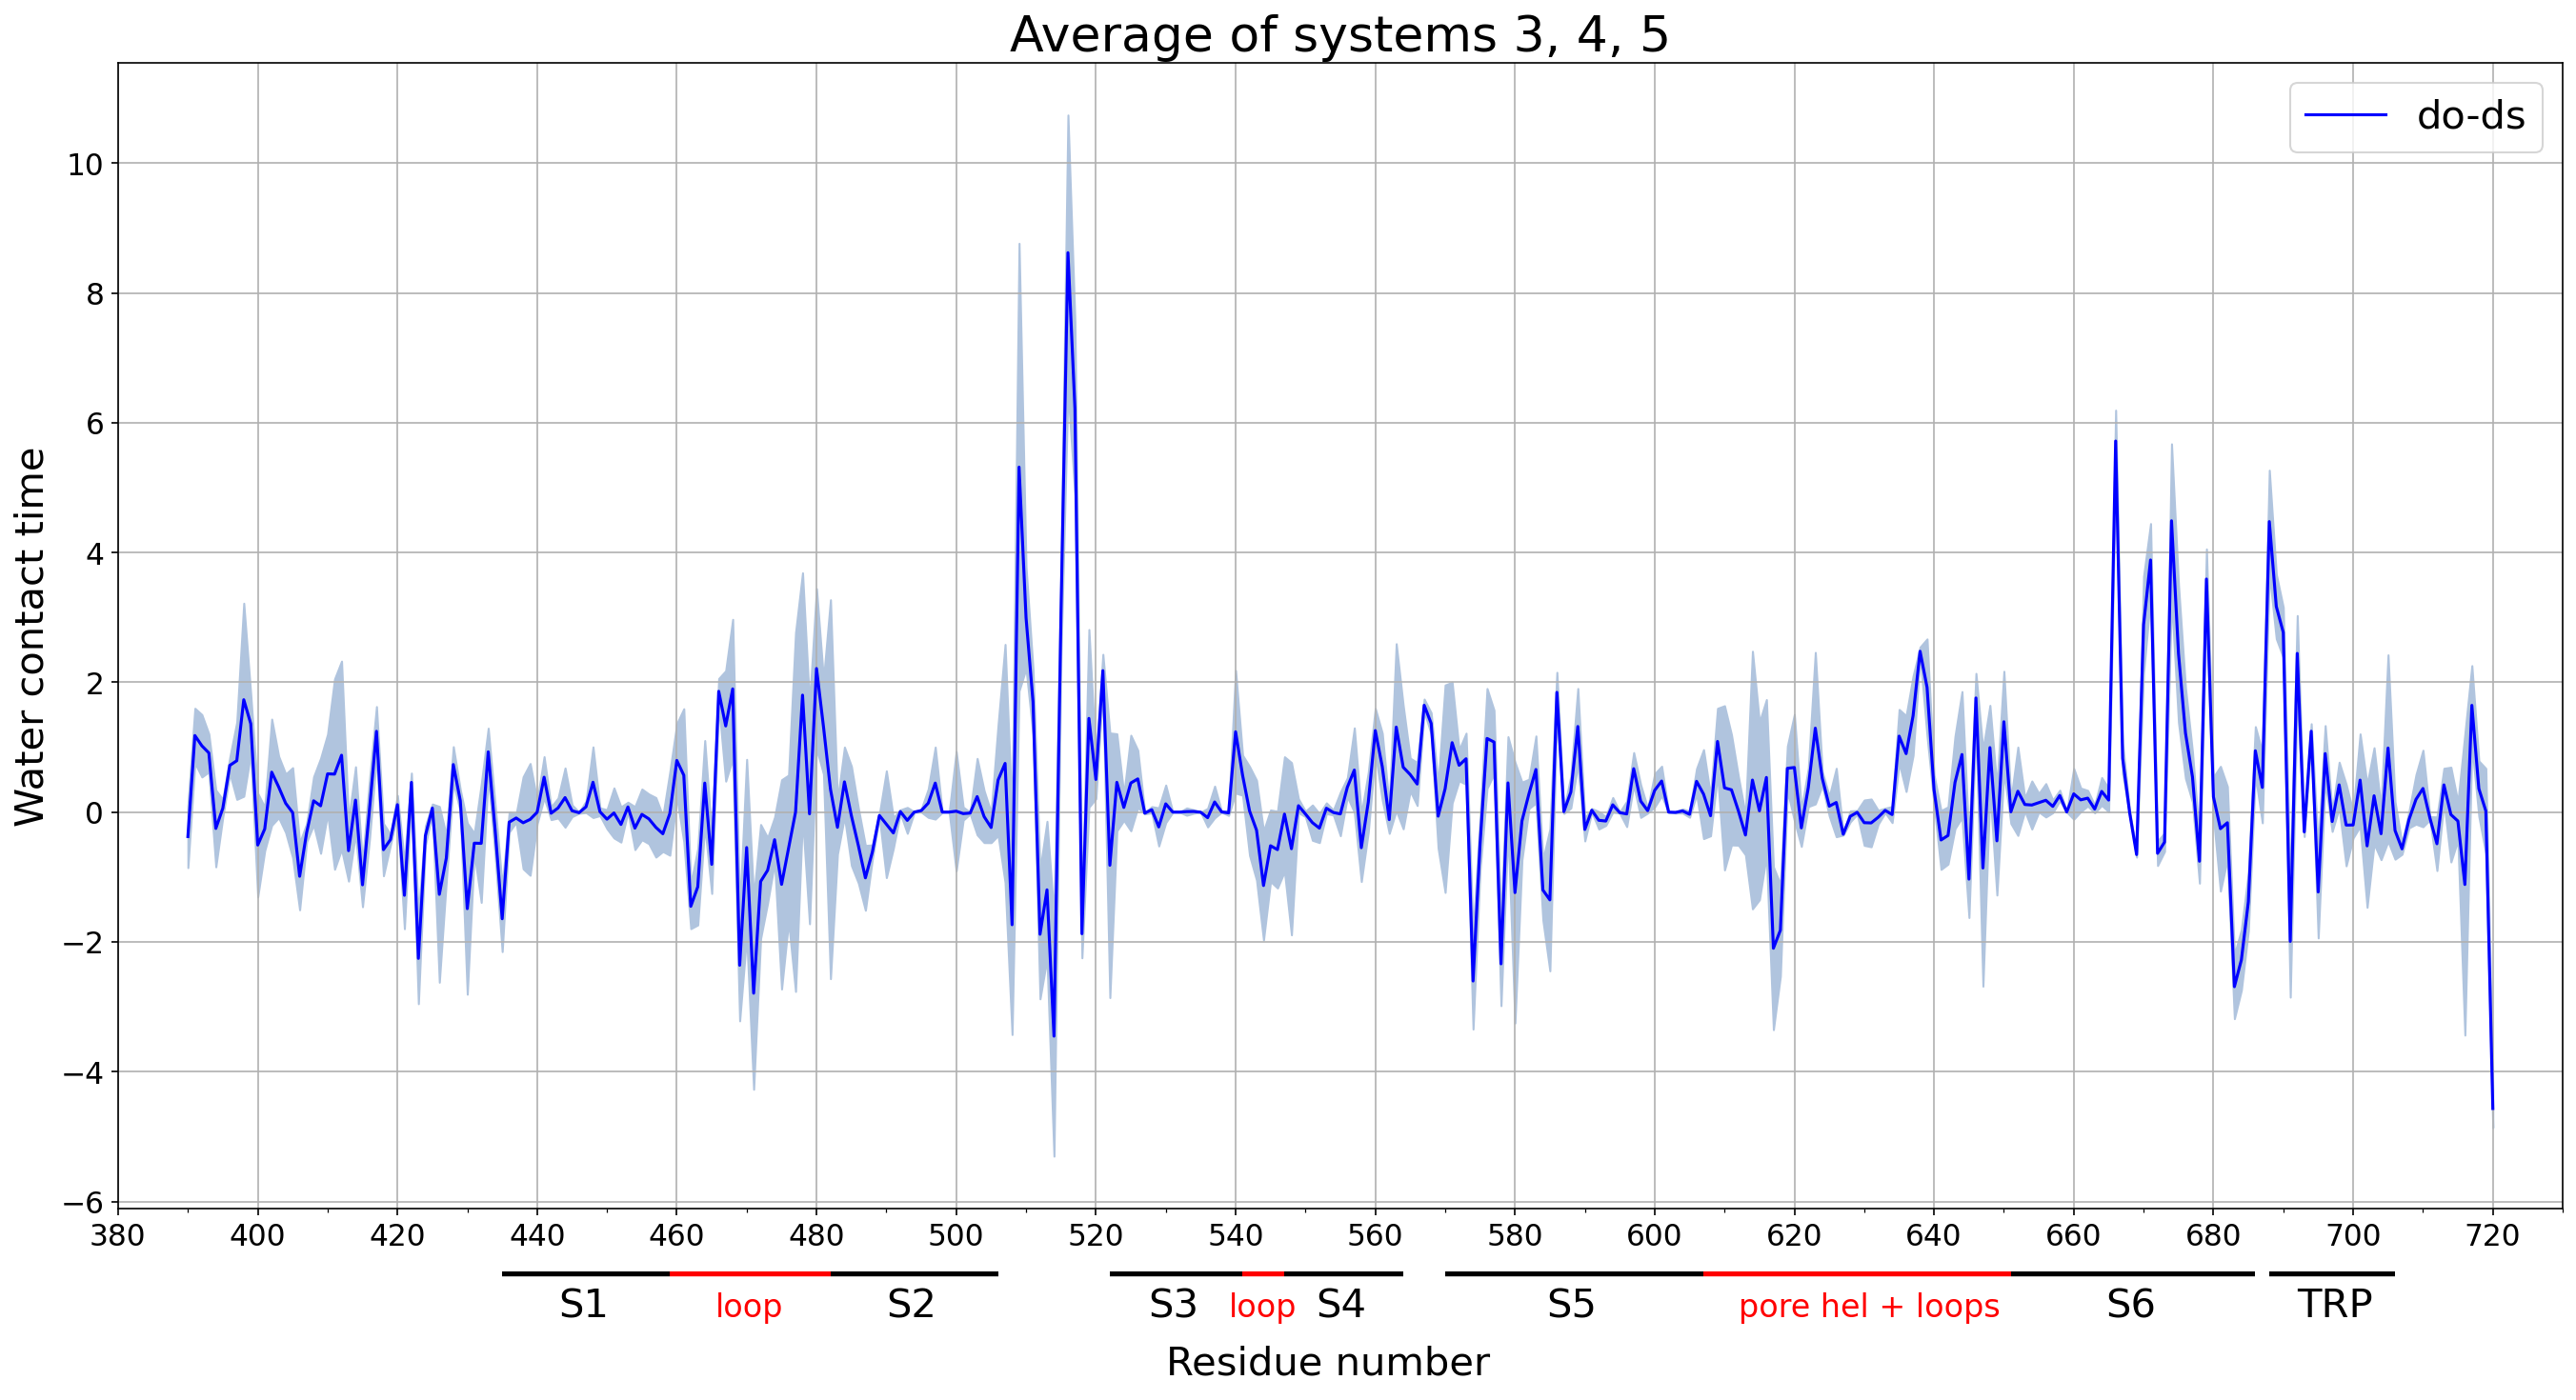

In [43]:
plt.style.use('default')
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(18)
fig.set_dpi(150)

gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[10, 1]) 

ax = plt.subplot(gs[0])
ax.set_xlim([380, 730])

from matplotlib import ticker
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))
plt.tick_params(axis='both', which='major', labelsize=15)


ax.plot(w_345.residue, w_345['do-ds_mean'], label='do-ds', c='blue')
ax.fill_between(w_345.residue, w_345['do-ds_mean']-w_345['do-ds_std'], w_345['do-ds_mean']+w_345['do-ds_std'], color='lightsteelblue')
#ax.set_xlabel('Residue', fontsize=15)
ax.set_ylabel('Water contact time', fontsize=20)
ax.set_title('Average of systems 3, 4, 5', fontsize=25)
ax.legend(prop={'size': 20})

# Подписи снизу
ax1 = plt.subplot(gs[1])
ax1.set_xlim([380, 730])
ax1.set_ylim([0, 1])
fig.tight_layout(pad=0.6)

regions = {'S1':(435, 459), 'S2':(482, 506), 'S3':(522, 541), 'S4':(547, 564), 'S5':(570, 607), 'TRP':(688, 706), 'S6':(651, 686)}
for reg in regions.keys():
    left = regions[reg][0]
    right = regions[reg][1]
    ax1.hlines(y=1, xmin=left, xmax=right, linewidths=5, color='black')
    xtext = (right-left)/2 + left - len(reg) - 2
    ax1.text(s=reg, x=xtext, y=0.6, c='black', fontsize=20)

loops = {'loop1':(459, 482), 'loop2':(541, 547), 'pore hel + loops_':(607, 651)}
for loop in loops.keys():
    left = loops[loop][0]
    right = loops[loop][1]
    name = loop[:-1]
    ax1.hlines(y=1, xmin=left, xmax=right, linewidths=5, color='red')
    xtext = (right-left)/2 + left - len(loop)
    ax1.text(s=name, x=xtext, y=0.6, c='red', fontsize=16)    

ax1.text(s='Residue number', x=530, y=0.1, c='black', fontsize=20)
#ax1.hlines(y=1, xmin=395, xmax=460, linewidths=5, color='black')
#ax1.text(s='S1', x=425.5, y=1.25, c='black', fontsize=20)
ax1.axis('off')
ax.grid()

## lipids

(380.0, 730.0, 0.0, 1.0)

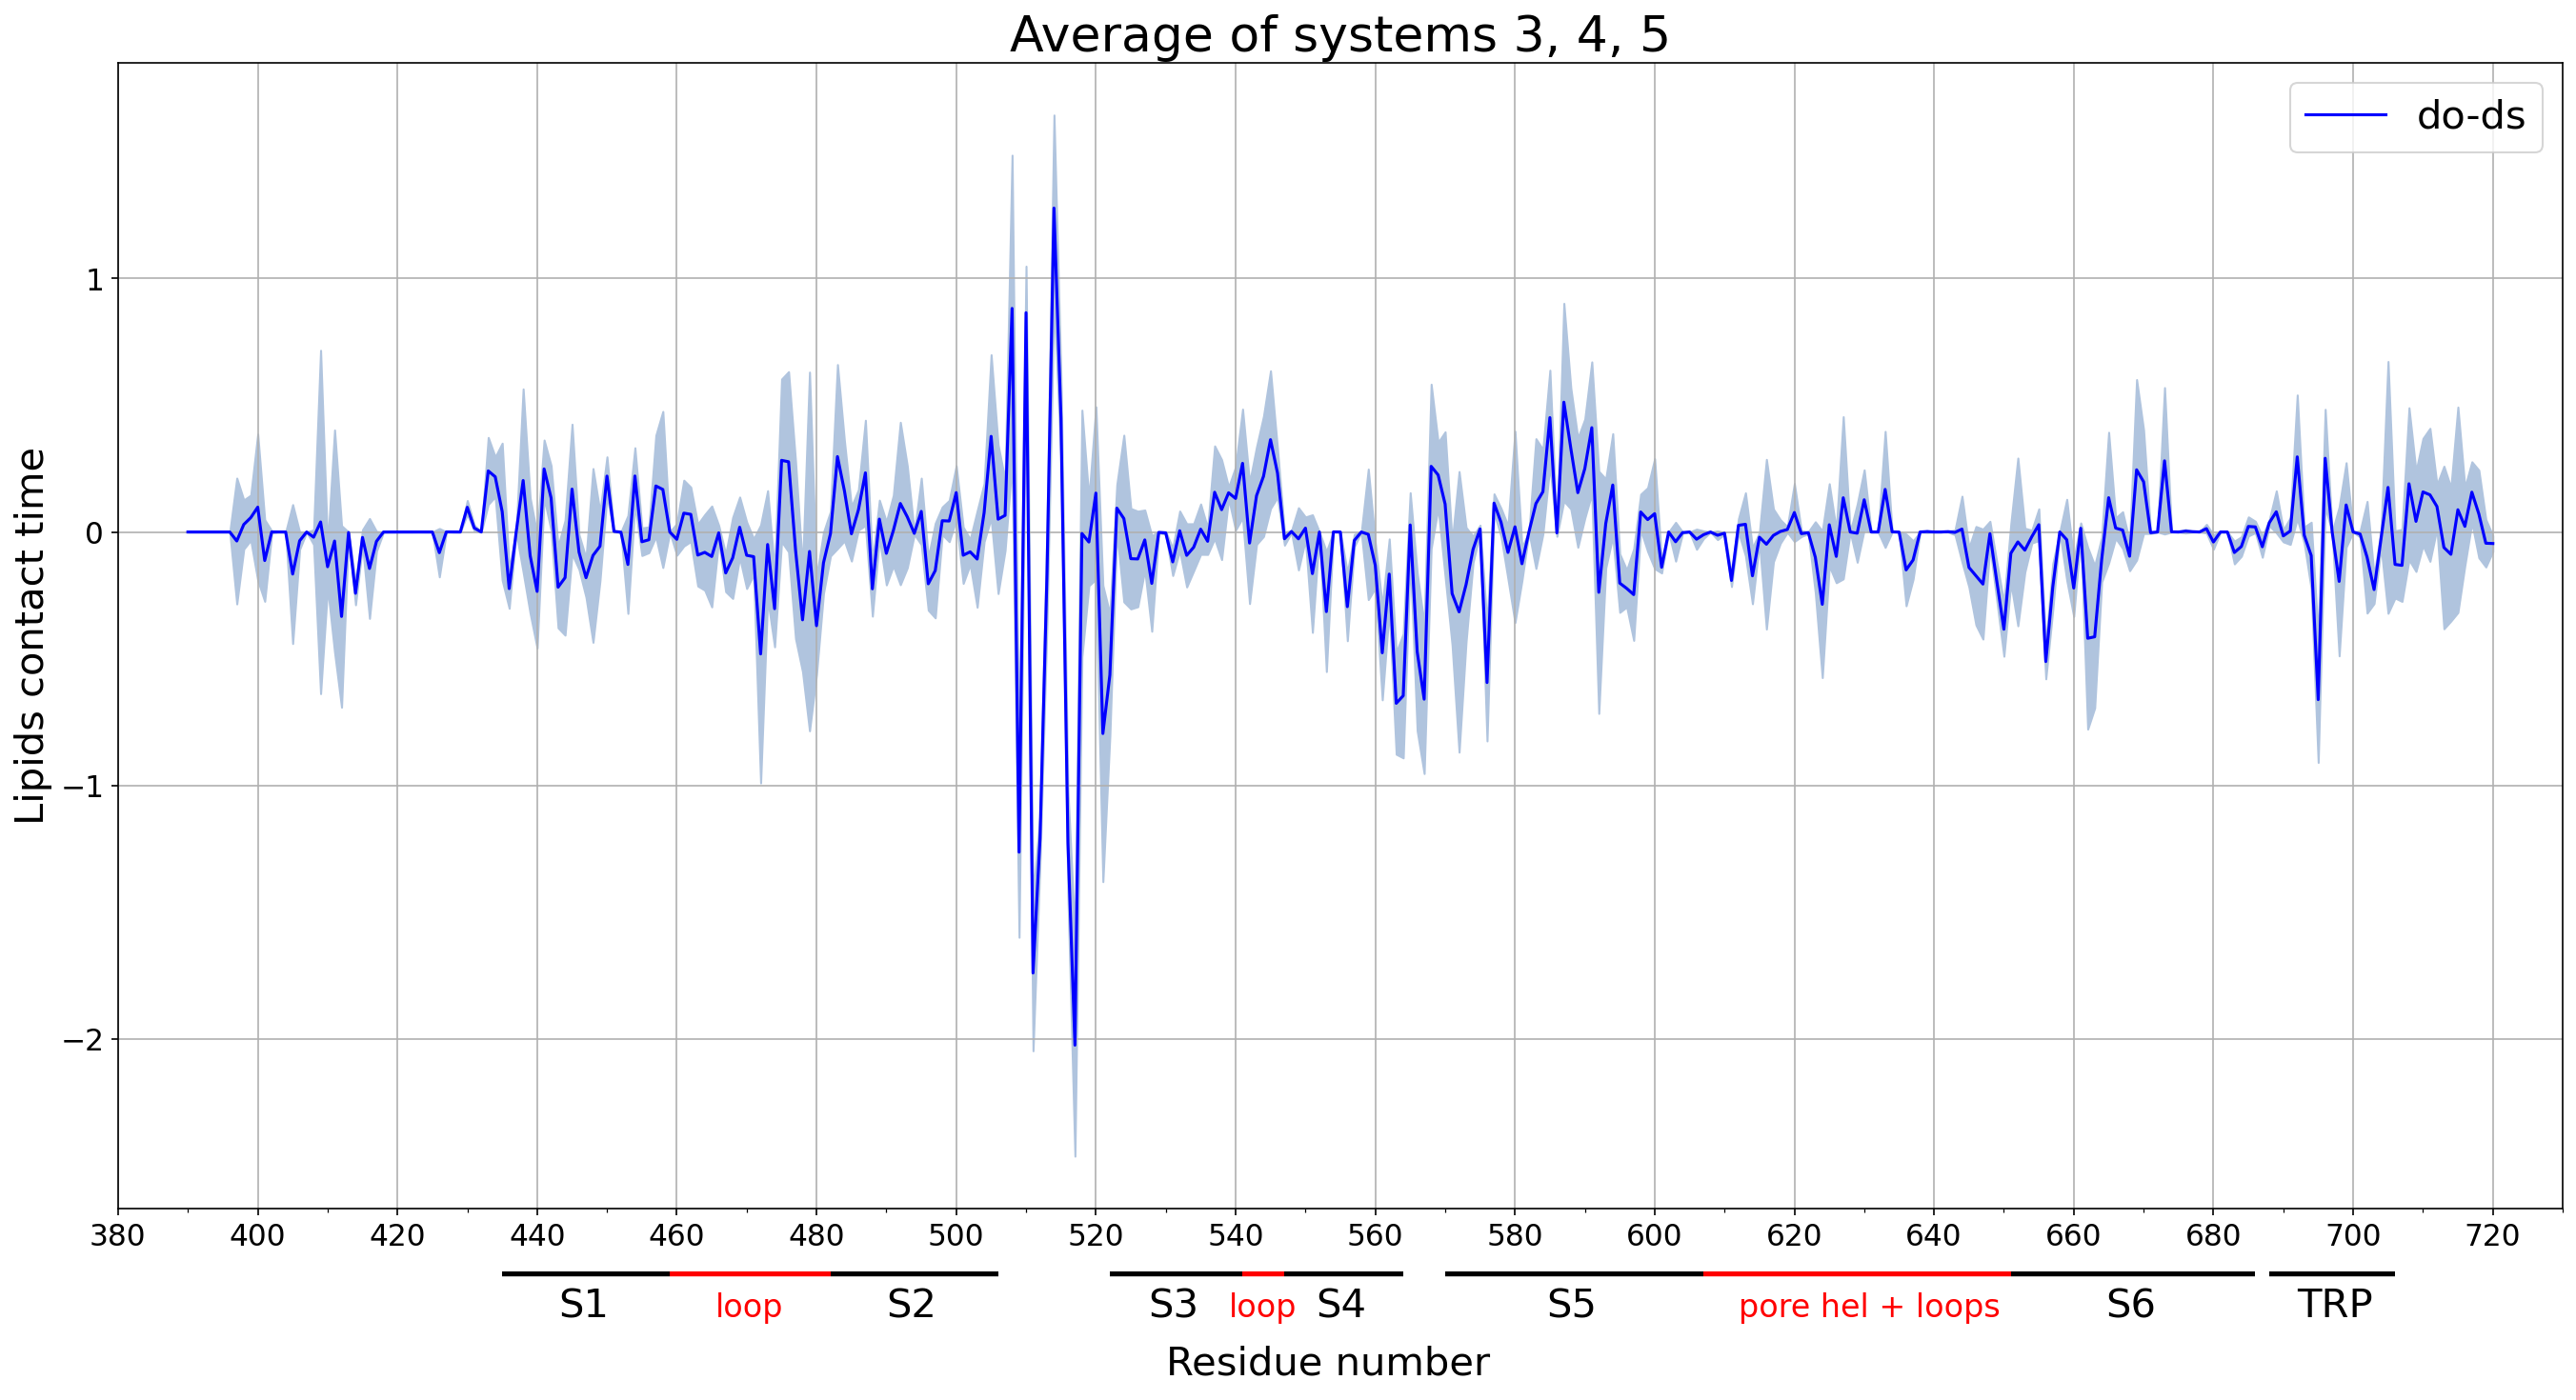

In [44]:
l_345 = l_3[['residue', 'do-ds_3']].merge(l_4[['residue', 'do-ds_4']], on='residue').merge(l_5[['residue', 'do-ds_5']], on='residue')
l_345['do-ds_mean'] = l_345.iloc[:, 1:].mean(axis=1)
l_345['do-ds_std'] = l_345.iloc[:, 1:].std(axis=1)

plt.style.use('default')
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(18)
fig.set_dpi(150)

gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[10, 1]) 

ax = plt.subplot(gs[0])
ax.set_xlim([380, 730])

from matplotlib import ticker
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))
plt.tick_params(axis='both', which='major', labelsize=15)

ax.plot(l_345.residue, l_345['do-ds_mean'], label='do-ds', c='blue')
ax.fill_between(l_345.residue, l_345['do-ds_mean']-l_345['do-ds_std'], l_345['do-ds_mean']+l_345['do-ds_std'], color='lightsteelblue')
#ax.set_xlabel('Residue', fontsize=15)
ax.set_ylabel('Lipids contact time', fontsize=20)
ax.set_title('Average of systems 3, 4, 5', fontsize=25)
ax.legend(prop={'size': 20})
ax.grid()

# Подписи снизу
ax1 = plt.subplot(gs[1])
ax1.set_xlim([380, 730])
ax1.set_ylim([0, 1])
fig.tight_layout(pad=0.6)

regions = {'S1':(435, 459), 'S2':(482, 506), 'S3':(522, 541), 'S4':(547, 564), 'S5':(570, 607), 'TRP':(688, 706), 'S6':(651, 686)}
for reg in regions.keys():
    left = regions[reg][0]
    right = regions[reg][1]
    ax1.hlines(y=1, xmin=left, xmax=right, linewidths=5, color='black')
    xtext = (right-left)/2 + left - len(reg) - 2
    ax1.text(s=reg, x=xtext, y=0.6, c='black', fontsize=20)

loops = {'loop1':(459, 482), 'loop2':(541, 547), 'pore hel + loops_':(607, 651)}
for loop in loops.keys():
    left = loops[loop][0]
    right = loops[loop][1]
    name = loop[:-1]
    ax1.hlines(y=1, xmin=left, xmax=right, linewidths=5, color='red')
    xtext = (right-left)/2 + left - len(loop)
    ax1.text(s=name, x=xtext, y=0.6, c='red', fontsize=16)    

ax1.text(s='Residue number', x=530, y=0.1, c='black', fontsize=20)
#ax1.hlines(y=1, xmin=395, xmax=460, linewidths=5, color='black')
#ax1.text(s='S1', x=425.5, y=1.25, c='black', fontsize=20)
ax1.axis('off')

In [47]:
l_345.to_csv('lipids_TRPV1.csv')
l_345

residue   do-ds_3   do-ds_4   do-ds_5  do-ds_mean  do-ds_std
0        390  0.000000  0.000000  0.000000    0.000000   0.000000
1        391  0.000000  0.000000  0.000000    0.000000   0.000000
2        392  0.000000  0.000000  0.000000    0.000000   0.000000
3        393  0.000000  0.000000  0.000000    0.000000   0.000000
4        394  0.000000  0.000000  0.000000    0.000000   0.000000
..       ...       ...       ...       ...         ...        ...
326      716 -0.007746 -0.149675  0.224013    0.022197   0.154020
327      717  0.129810  0.025862  0.315592    0.157088   0.119844
328      718 -0.029985 -0.070590  0.314343    0.071256   0.172686
329      719  0.034483 -0.175954  0.008662   -0.044270   0.093710
330      720 -0.078836 -0.053223 -0.004248   -0.045436   0.030944

[331 rows x 6 columns]

In [49]:
w_345.to_csv('water_TRPV1.csv')
w_345

residue   do-ds_3   do-ds_4   do-ds_5  do-ds_mean  do-ds_std
0        390 -0.412169  0.225887 -0.944153   -0.376812   0.478321
1        391  0.945652  1.771364  0.824963    1.180660   0.420587
2        392  0.484758  0.931409  1.651674    1.022614   0.480737
3        393  0.523613  1.227636  0.988381    0.913210   0.292290
4        394 -1.056222 -0.047726  0.350200   -0.251249   0.591930
..       ...       ...       ...       ...         ...        ...
326      716  1.194278 -0.250125 -4.290355   -1.115401   2.321182
327      717  2.485382  1.041854  1.411544    1.646260   0.612243
328      718 -0.222389  0.525237  0.784858    0.362569   0.426991
329      719  0.914418 -0.224013 -0.633308    0.019032   0.654812
330      720 -4.973138 -4.445027 -4.284733   -4.567633   0.294108

[331 rows x 6 columns]

In [50]:
import os
os.getcwd()

'C:\\Users\\alexander\\lab\\TRPV3'